# Import packages

In [29]:
#%pip install datasets
#%pip install accelerate -U
#%pip install transformers[torch]

Note: you may need to restart the kernel to use updated packages.


In [1]:
# General libraries
import os
import time
import multiprocessing
import warnings
import pickle
import re

# Data handling and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# NLP
from gensim.parsing.preprocessing import STOPWORDS, strip_punctuation, strip_multiple_whitespaces, remove_stopwords, strip_short

# Scikit-learn
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Pytorch
import torch

# Others
from datasets import Dataset,load_dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from transformers import AutoTokenizer, DistilBertForSequenceClassification
import tensorflow as tf

/home/nguyenk/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [2]:
# Get all training data files
path = '../datasets/distilbert_data/train/'
files = [file for file in os.listdir(path) if file.endswith('text_clean.csv')]
files

['NetCashProvidedByUsedInInvestingActivities_train__text_clean.csv',
 'EBIT_train__text_clean.csv',
 'NetCashProvidedByUsedInFinancingActivities_train__text_clean.csv',
 'RevenueFromContractWithCustomerExcludingAssessedTax_train__text_clean.csv',
 'NetIncomeLoss_train__text_clean.csv',
 'EarningsPerShareDiluted_train__text_clean.csv']

In [3]:
# Get all training data files
fb_path = '../datasets/finbert_data/train/'
fb_files = [file for file in os.listdir(fb_path) if file.endswith('text_clean.csv')]
fb_files

['NetCashProvidedByUsedInInvestingActivities_train__text_clean.csv',
 'EBIT_train__text_clean.csv',
 'NetCashProvidedByUsedInFinancingActivities_train__text_clean.csv',
 'RevenueFromContractWithCustomerExcludingAssessedTax_train__text_clean.csv',
 'NetIncomeLoss_train__text_clean.csv',
 'EarningsPerShareDiluted_train__text_clean.csv']

In [12]:
# Load first data
df = pd.read_csv(path + files[0])
df.head()

,text,item,cik,year,val
0,Management considers several factors in assess...,item_7,922224,2020,5429000000
1,We estimate the fair values of the assets acqu...,item_7,1020569,2020,4147270000
2,If actual future taxable income differs from o...,item_7,1050915,2016,7651319000
3,The Company expects that it will be subject to...,item_7,29905,2017,6820886000
4,If all of our accumulated unrepatriated Indian...,item_7,1058290,2019,16783000000


In [18]:
# Word count analysis
df['text_word_count'] = df['text'].apply(lambda x: len(str(x).split()))
print(df['text_word_count'].describe())

# Top frequent words or phrases
from collections import Counter

word_freq = Counter(" ".join(df['text']).split()).most_common(20)
print(word_freq)


count    6303.000000
mean       55.212914
std        71.854154
min         8.000000
25%        29.000000
50%        39.000000
75%        55.000000
max      1756.000000
Name: text_word_count, dtype: float64
[('the', 17309), ('of', 15302), ('and', 12390), ('to', 10004), ('in', 8181), ('our', 5472), ('tax', 4939), ('income', 4897), ('a', 3882), ('or', 3590), ('for', 3536), ('on', 3074), ('million', 2667), ('from', 2635), ('as', 2250), ('we', 2041), ('net', 2020), ('that', 1966), ('•', 1922), ('which', 1803)]


In [19]:
df = preprocess_text(df, 'val')
df.head()

,text,target
0,management considers factors assessing expecte...,5429000000
1,estimate fair values assets acquired acquisiti...,4147270000
2,actual future taxable income differs estimates...,7651319000
3,company expects subject incremental tax gilti ...,6820886000
4,accumulated unrepatriated indian earnings repa...,16783000000


In [20]:
# Word count analysis
df['text_word_count'] = df['text'].apply(lambda x: len(str(x).split()))
print(df['text_word_count'].describe())

# Top frequent words or phrases
from collections import Counter

word_freq = Counter(" ".join(df['text']).split()).most_common(20)
print(word_freq)


count    6303.000000
mean       32.128034
std        41.839020
min         3.000000
25%        17.000000
50%        22.000000
75%        32.000000
max      1028.000000
Name: text_word_count, dtype: float64
[('income', 6399), ('tax', 5582), ('million', 3239), ('net', 2280), ('future', 1860), ('cash', 1788), ('expected', 1666), ('notes', 1468), ('rate', 1464), ('proceeds', 1448), ('assets', 1387), ('estimated', 1371), ('rates', 1361), ('including', 1334), ('taxes', 1218), ('value', 1117), ('changes', 1091), ('related', 1081), ('operating', 979), ('taxable', 975)]


In [10]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 4 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-32GB


# Initialize model and tokenizer

In [8]:
model = RegressionModel.from_pretrained('yiyanghkust/finbert-pretrain', num_labels = 1)
tokenizer = AutoTokenizer.from_pretrained('yiyanghkust/finbert-pretrain')

Some weights of RegressionModel were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.10.attention.out_lin.weight', 'transformer.layer.3.attention.out_lin.bias', 'transformer.layer.6.attention.v_lin.weight', 'transformer.layer.5.ffn.lin1.weight', 'transformer.layer.2.output_layer_norm.weight', 'transformer.layer.10.attention.v_lin.weight', 'transformer.layer.11.ffn.lin1.bias', 'transformer.layer.9.sa_layer_norm.bias', 'transformer.layer.11.attention.k_lin.bias', 'transformer.layer.10.ffn.lin2.weight', 'transformer.layer.0.attention.v_lin.bias', 'transformer.layer.1.attention.q_lin.bias', 'transformer.layer.7.ffn.lin2.bias', 'transformer.layer.4.ffn.lin2.weight', 'transformer.layer.1.sa_layer_norm.bias', 'transformer.layer.4.attention.k_lin.weight', 'transformer.layer.5.ffn.lin2.bias', 'transformer.layer.7.sa_layer_norm.weight', 'transformer.layer.5.ffn.lin2.weight', 'transformer.layer.4.sa_layer_norm.bias', 'transf

# Tokenize text and prepare labeled datasets

In [4]:
# Train validation split
def train_val_split(df, test_size=0.2):
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=42)
    return train_df, val_df

In [4]:
def prepare_labeled_datasets(tokenizer, model, length, texts, labelsset):
  inputs=[]
  labels=[]
  for i in range(len(labelsset)):
    input=torch.tensor([tokenizer.encode(texts[i], add_special_tokens=True, padding='max_length',truncation=True, max_length=length)]).to(device) # Apply the tokenizer to get the token ids for each text, transform to tensors and send to GPU device
    label= torch.tensor([labelsset[i]]).to(device) # send the labels to the GPU device
    inputs.append(input)
    labels.append(label)
  inputs=torch.cat(inputs)  # add to the list of tensors
  labels=torch.cat(labels)  
  dataset = TensorDataset(inputs, labels) # Generate a labeled Tensor-Dataset for training
  return dataset

In [25]:
df = pd.read_csv(path + files[0])
df.head()

,text,target
0,fourth quarter 2018 expanded restructuring pla...,3.100000e+07
1,given quality diversity underlying real estate...,-7.340000e+08
2,cash flow amounts reduced realized gains inves...,-6.240000e+08
3,plan expand network tesla stores galleries ser...,-1.081085e+09
4,given quality diversity underlying real estate...,-3.611000e+09


In [ ]:
# Define batch size
batch_size = 16

for file in files:
    df = pd.read_csv(path + file)
    train_df, val_df = train_val_split(df, test_size=0.2)
    
    train_dataset = prepare_labeled_datasets(tokenizer, model, 512, train_df['text'].values, train_df['label'].values)
    val_dataset = prepare_labeled_datasets(tokenizer, model, 512, val_df['text'].values, val_df['label'].values)
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [50]:
batch_size = 16
train_dataset = prepare_labeled_datasets(tokenizer, model, 300, train_df['text'].values.tolist(), train_df['target'].values.tolist()) # Generate the training set
val_dataset = prepare_labeled_datasets(tokenizer, model, 300, val_df['text'].values.tolist(), val_df['target'].values.tolist()) # Generate the validation set
train_dataloader = DataLoader(train_dataset, batch_size=batch_size) # Split the training set into batches
val_dataloader = DataLoader(val_dataset, batch_size=batch_size) # Split the validation set into batches

# Train models

In [5]:
class RegressionModel(DistilBertForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
    
    def compute_rse_loss(self, predictions, labels):
        mse_predictions_labels = torch.nn.functional.mse_loss(predictions.view(-1), labels.view(-1).float())
        mean_labels = torch.mean(labels.float())
        mse_labels_mean = torch.nn.functional.mse_loss(labels.view(-1).float(), mean_labels.expand_as(labels).view(-1))
        rse = mse_predictions_labels / mse_labels_mean
        return rse
    
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None, labels=None):
        outputs = self.distilbert(
                            input_ids=input_ids,
                            attention_mask=attention_mask,
                            )

        predictions = self.classifier(outputs.last_hidden_state[:, 0])
        
        if labels is not None:
            # Calculate the RSE loss if labels are provided
            loss = self.compute_rse_loss(predictions, labels)
            return loss, predictions
        else:
            return predictions


In [6]:
def finbert_regressor():
    model = RegressionModel.from_pretrained('yiyanghkust/finbert-pretrain', num_labels = 1)
    tokenizer = AutoTokenizer.from_pretrained('yiyanghkust/finbert-pretrain')
    return model, tokenizer

In [7]:
def train_finbert_regressor(model, tokenizer, train_dataloader, val_dataloader, epochs=10, initial_lr=0.001, eps=1e-8):
    optimizer = torch.optim.AdamW(model.parameters(), lr=initial_lr, eps=eps)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
    train_losses = []
    val_losses = []
    best_val_loss = np.inf # Set initial best validation loss to infinity
    training_stats = []
    for epoch in tqdm(range(epochs)):
        t0 = time.time() # Start training time
        # =================================
        #              Training
        # =================================
        model.train()
        train_loss = 0
        for step, batch in enumerate(train_dataloader):
            b_input_ids = batch[0].to(device)
            b_labels = batch[1].to(device)
            optimizer.zero_grad()
            loss, predictions = model(b_input_ids, labels=b_labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Help prevent the "exploding gradients" problem by clipping the norm of the gradients to 1.0.
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        # =================================
        #               Validation
        # =================================
        #model.eval()
        #val_loss = 0
        #for batch in val_dataloader:
         #   b_input_ids = batch[0].to(device)
          #  b_labels = batch[1].to(device)
           # with torch.no_grad():
            #    loss, predictions = model(b_input_ids, labels=b_labels)
            #val_loss += loss.item()
        #avg_val_loss = val_loss / len(val_dataloader)
        #val_losses.append(avg_val_loss)
        
        #print(f'Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
        model.eval()
        with torch.no_grad():
                #preds_list = []
                #labels_list = []
                rse_list = []
                rse_sum = 0

                for batch in val_dataloader:
                    input_ids, labels = batch
                    input_ids.to(device)
                    labels.to(device)

                    outputs = model(input_ids=input_ids, labels=labels)
                    loss = outputs[0] # Access the loss from the outputs tuple
                
                    # Predictions from the model
                    preds = outputs[1]  # The predicted values are the second element of the tuple outputted by the model
                    #preds_list.extend(preds.cpu().numpy())
                    #labels_list.extend(labels.cpu().numpy())

                    # Calculate RSE
                    mse_predictions_labels = torch.nn.functional.mse_loss(preds[:, 0], labels.float()).item()
                    mean_labels = torch.mean(labels.float())
                    mse_labels_mean = torch.nn.functional.mse_loss(labels.float(), mean_labels.expand_as(labels)).item()
                    rse = mse_predictions_labels / mse_labels_mean
                    rse_list.append(rse)
                    rse_sum += rse

                avg_val_loss = rse_sum / len(val_dataloader)
                
                # Store the loss value for plotting the learning curve
                val_losses.append(avg_val_loss)        
            
        # Update scheduler
        scheduler.step()
        learning_rate = scheduler.optimizer.param_groups[0]['lr']
        
        # Save the model if the validation loss is the best we've seen so far.
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = model
            best_epoch = epoch+1
        training_time = time.time() - t0 # Track training time
        training_stats.append({'Epoch': epoch+1, 
                               'Training Loss': avg_train_loss, 
                               'Valid. Loss': avg_val_loss, 
                               'Training Time': training_time,
                               'Learning Rate': learning_rate})
    print(pd.DataFrame(training_stats).set_index('Epoch'))
    return best_model, train_losses, val_losses, best_epoch, best_val_loss

### Finbert regressor with CV

In [7]:
from sklearn.model_selection import KFold

def train_finbert_regressor(model, tokenizer, dataset, epochs=10, initial_lr=0.001, eps=1e-8, batch_size=16, cv=5, patience=3):
    optimizer = torch.optim.AdamW(model.parameters(), lr=initial_lr, eps=eps)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
    training_stats = []
    kfold = KFold(n_splits=cv, shuffle=True)  # Define the number of folds
    
    best_val_loss_overall = np.inf # Set initial best validation loss to infinity
    best_model_overall = None
    best_epoch_overall = 0
    best_fold_overall = 0
    all_train_losses = []
    all_val_losses = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"Fold {fold + 1}")
        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset = torch.utils.data.Subset(dataset, val_idx)

        train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size)

        best_val_loss = np.inf
        train_losses = []
        val_losses = []
        best_epoch = 0
        early_stopping_counter = 0
        for epoch in tqdm(range(epochs)):
            model.train()
            train_loss = 0

            for step, batch in enumerate(train_loader):
                b_input_ids = batch[0].to(device)
                b_labels = batch[1].to(device)
                optimizer.zero_grad()
                loss, _ = model(b_input_ids, labels=b_labels)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                train_loss += loss.item()
            
            avg_train_loss = train_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            model.eval()
            with torch.no_grad():
                val_loss = 0

                for batch in val_loader:
                    input_ids, labels = batch
                    input_ids.to(device)
                    labels.to(device)

                    outputs = model(input_ids=input_ids, labels=labels)
                    loss = outputs[0]
                    val_loss += loss.item()

                avg_val_loss = val_loss / len(val_loader)
                val_losses.append(avg_val_loss)
                
                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    best_epoch = epoch + 1
                    early_stopping_counter = 0
                    best_fold = fold + 1
                    best_model = model
                else:
                    early_stopping_counter += 1
                    if early_stopping_counter >= patience:
                        print(f"Early stopping at epoch {epoch + 1} in fold {fold + 1}")
                        break
            
            scheduler.step()

            training_stats.append({
                'Fold': fold + 1,
                'Epoch': epoch + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
            })

        print(f"Fold {fold + 1} - Best Validation Loss: {best_val_loss} at Epoch: {best_epoch}")
    
        # Save losses and model for this fold
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)
        
        # Save the best model for this fold
        if best_val_loss < best_val_loss_overall:
            best_val_loss_overall = best_val_loss
            best_model_overall = best_model
            best_epoch_overall = best_epoch
            best_fold_overall = best_fold
    return best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats

In [8]:
# Plot the learning curve from training_stats, filtered by fold
def plot_learning_curve(training_stats, fold):
    df = pd.DataFrame(training_stats)
    df = df[df['Fold'] == fold]
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(df['Epoch'], df['Training Loss'], label='Training Loss')
    ax.plot(df['Epoch'], df['Valid. Loss'], label='Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(f'Learning Curve (Fold {fold})')
    ax.legend()
    plt.show()

### CV on all DistilBERT data

#### NetCashProvidedByUsedInInvestingActivities - DistilBERT

--------------START TRAINING MODEL FOR NetCashProvidedByUsedInInvestingActivities--------------


Some weights of RegressionModel were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.6.output_layer_norm.weight', 'transformer.layer.11.output_layer_norm.bias', 'transformer.layer.4.ffn.lin2.bias', 'transformer.layer.9.attention.q_lin.bias', 'transformer.layer.9.attention.k_lin.weight', 'transformer.layer.8.sa_layer_norm.bias', 'transformer.layer.2.sa_layer_norm.bias', 'transformer.layer.0.ffn.lin1.bias', 'transformer.layer.1.sa_layer_norm.bias', 'transformer.layer.3.ffn.lin2.bias', 'transformer.layer.3.attention.k_lin.bias', 'transformer.layer.7.sa_layer_norm.weight', 'transformer.layer.6.attention.q_lin.bias', 'transformer.layer.5.attention.k_lin.weight', 'transformer.layer.0.ffn.lin1.weight', 'transformer.layer.3.sa_layer_norm.bias', 'transformer.layer.8.ffn.lin1.weight', 'transformer.layer.4.attention.out_lin.weight', 'transformer.layer.2.attention.v_lin.bias', 'transformer.layer.6.attention.k_lin.weight', 'tr

Fold 1


  8%|▊         | 3/40 [00:01<00:24,  1.53it/s]


Early stopping at epoch 4 in fold 1
Fold 1 - Best Validation Loss: 2.055717706680298 at Epoch: 1
Fold 2


  8%|▊         | 3/40 [00:02<00:25,  1.48it/s]


Early stopping at epoch 4 in fold 2
Fold 2 - Best Validation Loss: 2.7882080078125 at Epoch: 1
Fold 3


  8%|▊         | 3/40 [00:02<00:25,  1.47it/s]


Early stopping at epoch 4 in fold 3
Fold 3 - Best Validation Loss: 2.310673952102661 at Epoch: 1
Fold 4


  8%|▊         | 3/40 [00:02<00:25,  1.47it/s]


Early stopping at epoch 4 in fold 4
Fold 4 - Best Validation Loss: 4.1483259201049805 at Epoch: 1
Fold 5


  8%|▊         | 3/40 [00:02<00:25,  1.47it/s]


Early stopping at epoch 4 in fold 5
Fold 5 - Best Validation Loss: 8.410371780395508 at Epoch: 1
Fold 6


  8%|▊         | 3/40 [00:02<00:25,  1.47it/s]


Early stopping at epoch 4 in fold 6
Fold 6 - Best Validation Loss: 1.7770859003067017 at Epoch: 1
Fold 7


  8%|▊         | 3/40 [00:02<00:25,  1.47it/s]


Early stopping at epoch 4 in fold 7
Fold 7 - Best Validation Loss: 2.0067877769470215 at Epoch: 1
Fold 8


  8%|▊         | 3/40 [00:02<00:25,  1.46it/s]


Early stopping at epoch 4 in fold 8
Fold 8 - Best Validation Loss: 5.379610061645508 at Epoch: 1
Fold 9


  8%|▊         | 3/40 [00:02<00:25,  1.46it/s]


Early stopping at epoch 4 in fold 9
Fold 9 - Best Validation Loss: 4.2043681144714355 at Epoch: 1
Fold 10


  8%|▊         | 3/40 [00:02<00:25,  1.46it/s]

Early stopping at epoch 4 in fold 10
Fold 10 - Best Validation Loss: 2.8779804706573486 at Epoch: 1


Results from the best model
Fold with best validation RSE: 6
Best validation RSE: 1.78


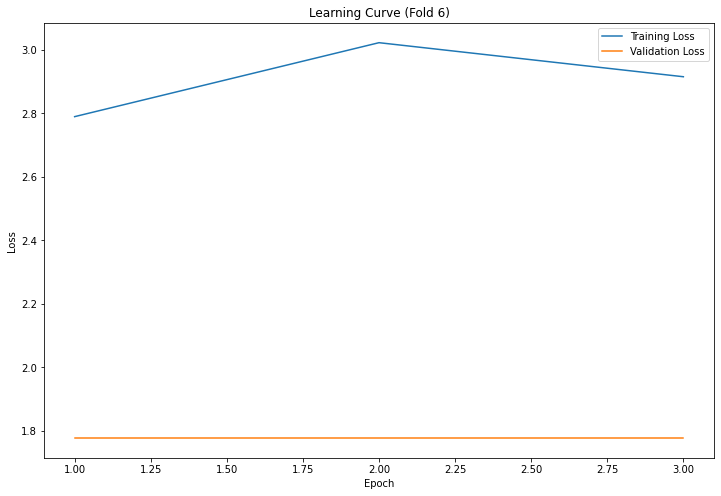

--------------DONE TRAINING MODEL FOR NetCashProvidedByUsedInInvestingActivities--------------




In [83]:
# Define variables
batch_size = 16
epochs=40
initial_lr=0.001
eps=1e-8
patience=3
cv=10
# Name metric
file = files[0]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(path + file)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Prepare dataset
dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

# Train model
best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset, 
                                                                                           epochs=epochs, initial_lr=initial_lr, 
                                                                                           eps=eps, cv=cv)

# Save models
#If folder not available, create folder
if not os.path.exists('../models/finbert-regression/distilbert_data/' + metric_name):
   os.makedirs('../models/finbert-regression/distilbert_data/' + metric_name)
# Save model to folder
best_model_overall.save_pretrained('../models/finbert-regression/distilbert_data/' + metric_name) 


# Present results from the best model
print("Results from the best model")
print(f"Fold with best validation RSE: {best_fold_overall}")
print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 

plot_learning_curve(training_stats,best_fold_overall)
print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
print("\n")

#### EBIT - DistilBERT

--------------START TRAINING MODEL FOR EBIT--------------


Some weights of RegressionModel were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.6.output_layer_norm.weight', 'transformer.layer.11.output_layer_norm.bias', 'transformer.layer.4.ffn.lin2.bias', 'transformer.layer.9.attention.q_lin.bias', 'transformer.layer.9.attention.k_lin.weight', 'transformer.layer.8.sa_layer_norm.bias', 'transformer.layer.2.sa_layer_norm.bias', 'transformer.layer.0.ffn.lin1.bias', 'transformer.layer.1.sa_layer_norm.bias', 'transformer.layer.3.ffn.lin2.bias', 'transformer.layer.3.attention.k_lin.bias', 'transformer.layer.7.sa_layer_norm.weight', 'transformer.layer.6.attention.q_lin.bias', 'transformer.layer.5.attention.k_lin.weight', 'transformer.layer.0.ffn.lin1.weight', 'transformer.layer.3.sa_layer_norm.bias', 'transformer.layer.8.ffn.lin1.weight', 'transformer.layer.4.attention.out_lin.weight', 'transformer.layer.2.attention.v_lin.bias', 'transformer.layer.6.attention.k_lin.weight', 'tr

Fold 1


  8%|▊         | 3/40 [00:11<02:22,  3.86s/it]


Early stopping at epoch 4 in fold 1
Fold 1 - Best Validation Loss: 1.822878360748291 at Epoch: 1
Fold 2


  8%|▊         | 3/40 [00:11<02:23,  3.87s/it]


Early stopping at epoch 4 in fold 2
Fold 2 - Best Validation Loss: 1.9356526136398315 at Epoch: 1
Fold 3


  8%|▊         | 3/40 [00:11<02:23,  3.89s/it]


Early stopping at epoch 4 in fold 3
Fold 3 - Best Validation Loss: 1.739360272884369 at Epoch: 1
Fold 4


  8%|▊         | 3/40 [00:11<02:24,  3.92s/it]


Early stopping at epoch 4 in fold 4
Fold 4 - Best Validation Loss: 3.721317946910858 at Epoch: 1
Fold 5


  8%|▊         | 3/40 [00:11<02:24,  3.91s/it]


Early stopping at epoch 4 in fold 5
Fold 5 - Best Validation Loss: 17.167556762695312 at Epoch: 1
Fold 6


  8%|▊         | 3/40 [00:11<02:24,  3.92s/it]


Early stopping at epoch 4 in fold 6
Fold 6 - Best Validation Loss: 29.734962344169617 at Epoch: 1
Fold 7


  8%|▊         | 3/40 [00:11<02:25,  3.93s/it]


Early stopping at epoch 4 in fold 7
Fold 7 - Best Validation Loss: 3.3326252698898315 at Epoch: 1
Fold 8


  8%|▊         | 3/40 [00:11<02:25,  3.93s/it]


Early stopping at epoch 4 in fold 8
Fold 8 - Best Validation Loss: 3.1435176134109497 at Epoch: 1
Fold 9


  8%|▊         | 3/40 [00:11<02:25,  3.92s/it]


Early stopping at epoch 4 in fold 9
Fold 9 - Best Validation Loss: 10.312436580657959 at Epoch: 1
Fold 10


  8%|▊         | 3/40 [00:11<02:25,  3.92s/it]

Early stopping at epoch 4 in fold 10
Fold 10 - Best Validation Loss: 1.8071548342704773 at Epoch: 1


Results from the best model
Fold with best validation RSE: 3
Best validation RSE: 1.74


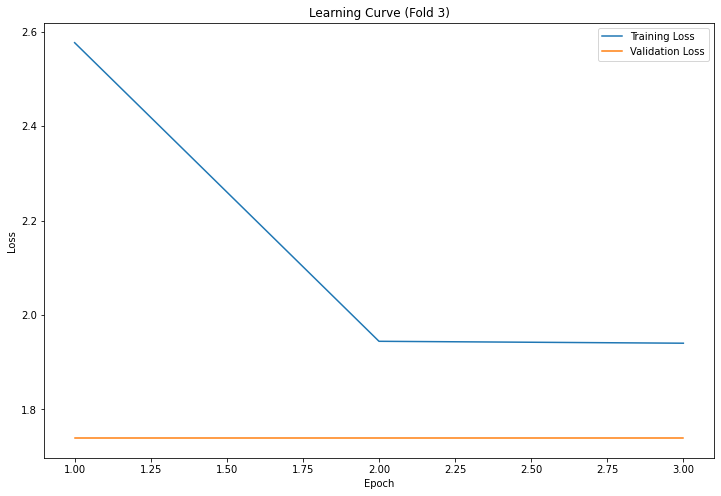

--------------DONE TRAINING MODEL FOR EBIT--------------




In [81]:
# Define variables
batch_size = 16
epochs=40
initial_lr=0.001
eps=1e-8
patience=5
cv=10
# Name metric
file = files[1]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(path + file)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Prepare dataset
dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

# Train model
best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset, 
                                                                                           epochs=epochs, initial_lr=initial_lr, 
                                                                                           eps=eps, cv=cv)

# Save models
#If folder not available, create folder
if not os.path.exists('../models/finbert-regression/distilbert_data/' + metric_name):
   os.makedirs('../models/finbert-regression/distilbert_data/' + metric_name)
# Save model to folder
best_model_overall.save_pretrained('../models/finbert-regression/distilbert_data/' + metric_name) 


# Present results from the best model
print("Results from the best model")
print(f"Fold with best validation RSE: {best_fold_overall}")
print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 

plot_learning_curve(training_stats,best_fold_overall)
print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
print("\n")

#### NetCashProvidedByUsedInFinancingActivities - DistilBERT

In [85]:
# Define variables
batch_size = 8
epochs=40
initial_lr=0.00001
eps=1e-8
patience=3
cv=10
# Name metric
file = files[2]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(path + file)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Prepare dataset
dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

# Train model
best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset, 
                                                                                           epochs=epochs, initial_lr=initial_lr, 
                                                                                           eps=eps, cv=cv)

# Save models
#If folder not available, create folder
if not os.path.exists('../models/finbert-regression/distilbert_data/' + metric_name):
   os.makedirs('../models/finbert-regression/distilbert_data/' + metric_name)
# Save model to folder
best_model_overall.save_pretrained('../models/finbert-regression/distilbert_data/' + metric_name) 


# Present results from the best model
print("Results from the best model")
print(f"Fold with best validation RSE: {best_fold_overall}")
print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 

plot_learning_curve(training_stats,best_fold_overall)
print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
print("\n")

--------------START TRAINING MODEL FOR NetCashProvidedByUsedInFinancingActivities--------------


Some weights of RegressionModel were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.6.output_layer_norm.weight', 'transformer.layer.11.output_layer_norm.bias', 'transformer.layer.4.ffn.lin2.bias', 'transformer.layer.9.attention.q_lin.bias', 'transformer.layer.9.attention.k_lin.weight', 'transformer.layer.8.sa_layer_norm.bias', 'transformer.layer.2.sa_layer_norm.bias', 'transformer.layer.0.ffn.lin1.bias', 'transformer.layer.1.sa_layer_norm.bias', 'transformer.layer.3.ffn.lin2.bias', 'transformer.layer.3.attention.k_lin.bias', 'transformer.layer.7.sa_layer_norm.weight', 'transformer.layer.6.attention.q_lin.bias', 'transformer.layer.5.attention.k_lin.weight', 'transformer.layer.0.ffn.lin1.weight', 'transformer.layer.3.sa_layer_norm.bias', 'transformer.layer.8.ffn.lin1.weight', 'transformer.layer.4.attention.out_lin.weight', 'transformer.layer.2.attention.v_lin.bias', 'transformer.layer.6.attention.k_lin.weight', 'tr

Fold 1


  5%|▌         | 2/40 [00:00<00:18,  2.02it/s]


Early stopping at epoch 3 in fold 1
Fold 1 - Best Validation Loss: inf at Epoch: 0
Fold 2


  5%|▌         | 2/40 [00:00<00:18,  2.08it/s]


Early stopping at epoch 3 in fold 2
Fold 2 - Best Validation Loss: inf at Epoch: 0
Fold 3


  5%|▌         | 2/40 [00:00<00:18,  2.07it/s]


Early stopping at epoch 3 in fold 3
Fold 3 - Best Validation Loss: inf at Epoch: 0
Fold 4


  5%|▌         | 2/40 [00:00<00:18,  2.07it/s]


Early stopping at epoch 3 in fold 4
Fold 4 - Best Validation Loss: inf at Epoch: 0
Fold 5


  5%|▌         | 2/40 [00:00<00:18,  2.08it/s]


Early stopping at epoch 3 in fold 5
Fold 5 - Best Validation Loss: inf at Epoch: 0
Fold 6


  5%|▌         | 2/40 [00:00<00:18,  2.08it/s]


Early stopping at epoch 3 in fold 6
Fold 6 - Best Validation Loss: inf at Epoch: 0
Fold 7


  5%|▌         | 2/40 [00:00<00:18,  2.08it/s]


Early stopping at epoch 3 in fold 7
Fold 7 - Best Validation Loss: inf at Epoch: 0
Fold 8


  5%|▌         | 2/40 [00:00<00:18,  2.08it/s]


Early stopping at epoch 3 in fold 8
Fold 8 - Best Validation Loss: inf at Epoch: 0
Fold 9


  5%|▌         | 2/40 [00:00<00:18,  2.08it/s]


Early stopping at epoch 3 in fold 9
Fold 9 - Best Validation Loss: inf at Epoch: 0
Fold 10


  5%|▌         | 2/40 [00:00<00:18,  2.03it/s]

Early stopping at epoch 3 in fold 10
Fold 10 - Best Validation Loss: inf at Epoch: 0


AttributeError: 'NoneType' object has no attribute 'save_pretrained'

#### Revenue - DistilBERT

--------------START TRAINING MODEL FOR RevenueFromContractWithCustomerExcludingAssessedTax--------------


Some weights of RegressionModel were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.11.ffn.lin2.bias', 'transformer.layer.8.attention.k_lin.bias', 'transformer.layer.11.sa_layer_norm.bias', 'transformer.layer.11.attention.k_lin.weight', 'embeddings.position_embeddings.weight', 'transformer.layer.2.ffn.lin1.weight', 'transformer.layer.2.attention.v_lin.weight', 'transformer.layer.8.sa_layer_norm.bias', 'transformer.layer.1.output_layer_norm.bias', 'transformer.layer.3.ffn.lin2.weight', 'transformer.layer.8.sa_layer_norm.weight', 'transformer.layer.0.sa_layer_norm.weight', 'transformer.layer.4.attention.out_lin.weight', 'transformer.layer.10.attention.q_lin.weight', 'transformer.layer.6.attention.out_lin.bias', 'transformer.layer.1.ffn.lin1.weight', 'transformer.layer.8.ffn.lin1.weight', 'transformer.layer.2.sa_layer_norm.bias', 'transformer.layer.0.attention.v_lin.weight', 'transformer.layer.2.attention.q_lin.bias

Fold 1


  8%|▊         | 3/40 [06:54<1:25:07, 138.03s/it]


Early stopping at epoch 4 in fold 1
Fold 1 - Best Validation Loss: 2.5364104926586153 at Epoch: 1
Fold 2


  8%|▊         | 3/40 [06:53<1:24:54, 137.70s/it]


Early stopping at epoch 4 in fold 2
Fold 2 - Best Validation Loss: 2.70484012067318 at Epoch: 1
Fold 3


  8%|▊         | 3/40 [06:52<1:24:47, 137.50s/it]


Early stopping at epoch 4 in fold 3
Fold 3 - Best Validation Loss: 2.5640236735343933 at Epoch: 1
Fold 4


  8%|▊         | 3/40 [06:52<1:24:52, 137.64s/it]


Early stopping at epoch 4 in fold 4
Fold 4 - Best Validation Loss: 2.6903500318527223 at Epoch: 1
Fold 5


  8%|▊         | 3/40 [06:52<1:24:47, 137.51s/it]


Early stopping at epoch 4 in fold 5
Fold 5 - Best Validation Loss: 2.4359578043222427 at Epoch: 1
Fold 6


  8%|▊         | 3/40 [06:52<1:24:50, 137.58s/it]


Early stopping at epoch 4 in fold 6
Fold 6 - Best Validation Loss: 2.3811273008584974 at Epoch: 1
Fold 7


  8%|▊         | 3/40 [06:52<1:24:44, 137.43s/it]


Early stopping at epoch 4 in fold 7
Fold 7 - Best Validation Loss: 2.393910300731659 at Epoch: 1
Fold 8


  8%|▊         | 3/40 [06:51<1:24:34, 137.15s/it]


Early stopping at epoch 4 in fold 8
Fold 8 - Best Validation Loss: 2.4991341322660445 at Epoch: 1
Fold 9


  8%|▊         | 3/40 [06:51<1:24:38, 137.26s/it]


Early stopping at epoch 4 in fold 9
Fold 9 - Best Validation Loss: 2.6057889848947524 at Epoch: 1
Fold 10


  8%|▊         | 3/40 [06:51<1:24:37, 137.23s/it]

Early stopping at epoch 4 in fold 10
Fold 10 - Best Validation Loss: 2.6167310953140257 at Epoch: 1


Results from the best model
Fold with best validation RSE: 6
Best validation RSE: 2.38


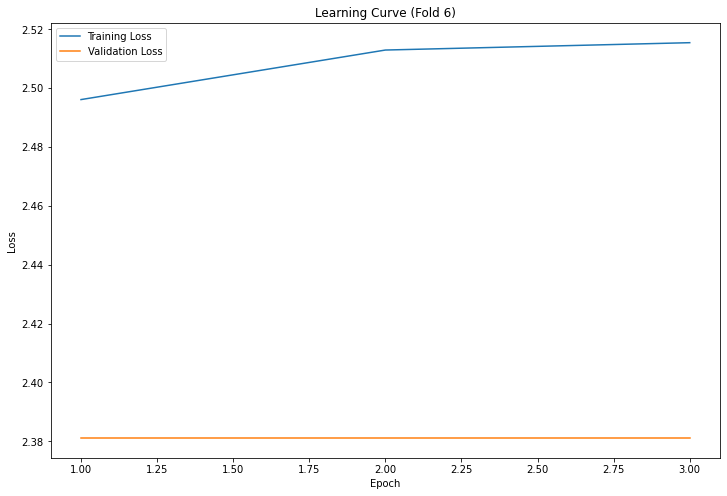

--------------DONE TRAINING MODEL FOR RevenueFromContractWithCustomerExcludingAssessedTax--------------




In [10]:
# Define variables
batch_size = 32
epochs=40
initial_lr=0.0001
eps=1e-8
patience=5
cv=10
# Name metric
file = files[3]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(path + file)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Prepare dataset
dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

# Train model
best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset, 
                                                                                           epochs=epochs, initial_lr=initial_lr, 
                                                                                           eps=eps, cv=cv) 

# Save models
#If folder not available, create folder
if not os.path.exists('../models/finbert-regression/distilbert_data/' + metric_name):
   os.makedirs('../models/finbert-regression/distilbert_data/' + metric_name)
# Save model to folder
best_model_overall.save_pretrained('../models/finbert-regression/distilbert_data/' + metric_name) 

# Present results from the best model
print("Results from the best model")
print(f"Fold with best validation RSE: {best_fold_overall}")
print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 

plot_learning_curve(training_stats,best_fold_overall)
print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
print("\n")

#### NetIncomeLoss - DistilBERT

--------------START TRAINING MODEL FOR NetIncomeLoss--------------


Some weights of RegressionModel were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.11.ffn.lin2.weight', 'transformer.layer.8.attention.out_lin.weight', 'transformer.layer.1.ffn.lin2.bias', 'transformer.layer.11.ffn.lin2.bias', 'transformer.layer.1.sa_layer_norm.bias', 'transformer.layer.0.attention.v_lin.bias', 'transformer.layer.4.sa_layer_norm.bias', 'transformer.layer.4.output_layer_norm.bias', 'transformer.layer.2.ffn.lin2.weight', 'transformer.layer.4.ffn.lin1.weight', 'transformer.layer.0.attention.out_lin.bias', 'transformer.layer.8.ffn.lin2.weight', 'transformer.layer.6.sa_layer_norm.bias', 'transformer.layer.0.attention.k_lin.bias', 'transformer.layer.4.attention.k_lin.bias', 'transformer.layer.4.ffn.lin2.bias', 'transformer.layer.6.output_layer_norm.bias', 'transformer.layer.1.ffn.lin1.bias', 'transformer.layer.9.attention.k_lin.bias', 'embeddings.position_embeddings.weight', 'transformer.layer.9.atten

Fold 1


 75%|███████▌  | 30/40 [1:17:17<25:45, 154.58s/it]


Early stopping at epoch 31 in fold 1
Fold 1 - Best Validation Loss: 2.0431942249599255 at Epoch: 28
Fold 2


 20%|██        | 8/40 [22:48<1:31:15, 171.11s/it]


Early stopping at epoch 9 in fold 2
Fold 2 - Best Validation Loss: 2.0379712665290164 at Epoch: 6
Fold 3


  8%|▊         | 3/40 [10:14<2:06:20, 204.89s/it]


Early stopping at epoch 4 in fold 3
Fold 3 - Best Validation Loss: 2.0868071129447534 at Epoch: 1
Fold 4


  8%|▊         | 3/40 [10:16<2:06:38, 205.37s/it]


Early stopping at epoch 4 in fold 4
Fold 4 - Best Validation Loss: 1.9950432819232606 at Epoch: 1
Fold 5


 15%|█▌        | 6/40 [17:58<1:41:50, 179.72s/it]


Early stopping at epoch 7 in fold 5
Fold 5 - Best Validation Loss: 2.012339606619718 at Epoch: 4
Fold 6


  8%|▊         | 3/40 [10:15<2:06:26, 205.04s/it]


Early stopping at epoch 4 in fold 6
Fold 6 - Best Validation Loss: 2.0257806464245447 at Epoch: 1
Fold 7


  8%|▊         | 3/40 [10:16<2:06:38, 205.36s/it]


Early stopping at epoch 4 in fold 7
Fold 7 - Best Validation Loss: 2.00247273528785 at Epoch: 1
Fold 8


  8%|▊         | 3/40 [10:14<2:06:24, 204.98s/it]


Early stopping at epoch 4 in fold 8
Fold 8 - Best Validation Loss: 1.97663288367422 at Epoch: 1
Fold 9


 12%|█▎        | 5/40 [15:24<1:47:50, 184.87s/it]


Early stopping at epoch 6 in fold 9
Fold 9 - Best Validation Loss: 2.070492225780822 at Epoch: 3
Fold 10


  8%|▊         | 3/40 [10:18<2:07:02, 206.02s/it]

Early stopping at epoch 4 in fold 10
Fold 10 - Best Validation Loss: 2.1824552385430587 at Epoch: 1
Results from the best model
Fold with best validation RSE: 8
Best validation RSE: 1.98


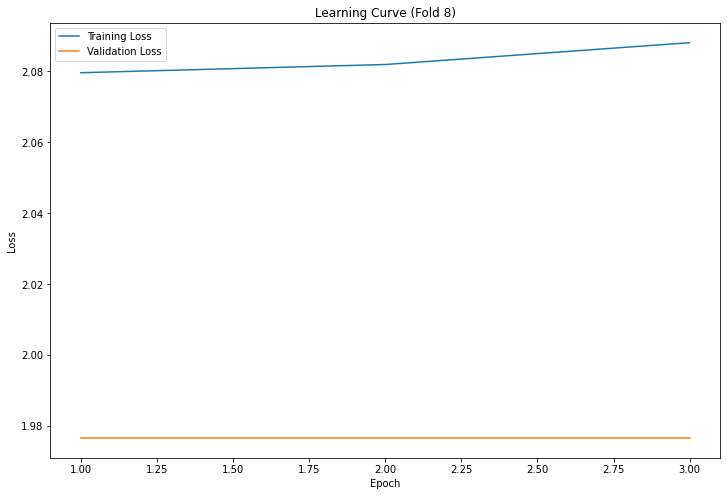

--------------DONE TRAINING MODEL FOR NetIncomeLoss--------------




In [15]:
# Define variables
batch_size = 32
epochs=40
initial_lr=0.001
eps=1e-8
patience=5
cv=10
# Name metric
file = files[4]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(path + file)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Prepare dataset
dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

# Train model
best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset, 
                                                                                           epochs=epochs, initial_lr=initial_lr, 
                                                                                           eps=eps, cv=cv)  

# Save models
#If folder not available, create folder
if not os.path.exists('../models/finbert-regression/distilbert_data/' + metric_name):
   os.makedirs('../models/finbert-regression/distilbert_data/' + metric_name)
# Save model to folder
best_model_overall.save_pretrained('../models/finbert-regression/distilbert_data/' + metric_name) 

# Present results from the best model
print("Results from the best model")
print(f"Fold with best validation RSE: {best_fold_overall}")
print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 

plot_learning_curve(training_stats,best_fold_overall)
print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
print("\n")

#### EPS - DistilBERT

--------------START TRAINING MODEL FOR EarningsPerShareDiluted--------------


Some weights of RegressionModel were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.5.sa_layer_norm.weight', 'transformer.layer.2.ffn.lin1.weight', 'transformer.layer.2.attention.k_lin.weight', 'transformer.layer.2.attention.out_lin.weight', 'transformer.layer.3.ffn.lin2.weight', 'transformer.layer.4.ffn.lin1.bias', 'transformer.layer.6.sa_layer_norm.weight', 'transformer.layer.10.sa_layer_norm.weight', 'transformer.layer.11.output_layer_norm.bias', 'transformer.layer.7.attention.k_lin.weight', 'transformer.layer.7.ffn.lin2.bias', 'embeddings.LayerNorm.weight', 'transformer.layer.11.attention.k_lin.bias', 'transformer.layer.2.sa_layer_norm.weight', 'transformer.layer.7.attention.q_lin.bias', 'transformer.layer.2.output_layer_norm.bias', 'transformer.layer.2.attention.q_lin.weight', 'transformer.layer.0.ffn.lin1.weight', 'transformer.layer.0.attention.k_lin.weight', 'transformer.layer.5.ffn.lin1.weight', 'transfor

Fold 1


 12%|█▎        | 5/40 [00:35<04:05,  7.03s/it]


Early stopping at epoch 6 in fold 1
Fold 1 - Best Validation Loss: 1.217782696088155 at Epoch: 3
Fold 2


 12%|█▎        | 5/40 [00:34<04:03,  6.97s/it]


Early stopping at epoch 6 in fold 2
Fold 2 - Best Validation Loss: 1.0327089230219524 at Epoch: 3
Fold 3


 10%|█         | 4/40 [00:29<04:24,  7.34s/it]


Early stopping at epoch 5 in fold 3
Fold 3 - Best Validation Loss: 1.7801703612009685 at Epoch: 2
Fold 4


 10%|█         | 4/40 [00:29<04:23,  7.33s/it]


Early stopping at epoch 5 in fold 4
Fold 4 - Best Validation Loss: 1.2930190960566204 at Epoch: 2
Fold 5


 12%|█▎        | 5/40 [00:35<04:05,  7.01s/it]


Early stopping at epoch 6 in fold 5
Fold 5 - Best Validation Loss: 1.1475634177525837 at Epoch: 3
Fold 6


 15%|█▌        | 6/40 [00:41<03:53,  6.86s/it]


Early stopping at epoch 7 in fold 6
Fold 6 - Best Validation Loss: 1.137869914372762 at Epoch: 4
Fold 7


 20%|██        | 8/40 [00:52<03:31,  6.60s/it]


Early stopping at epoch 9 in fold 7
Fold 7 - Best Validation Loss: 1.4556564092636108 at Epoch: 6
Fold 8


  8%|▊         | 3/40 [00:23<04:50,  7.86s/it]


Early stopping at epoch 4 in fold 8
Fold 8 - Best Validation Loss: 1.186899741490682 at Epoch: 1
Fold 9


 12%|█▎        | 5/40 [00:35<04:06,  7.04s/it]


Early stopping at epoch 6 in fold 9
Fold 9 - Best Validation Loss: 1.558605392773946 at Epoch: 3
Fold 10


  8%|▊         | 3/40 [00:23<04:46,  7.76s/it]

Early stopping at epoch 4 in fold 10
Fold 10 - Best Validation Loss: 1.26923934618632 at Epoch: 1


Results from the best model
Fold with best validation RSE: 2
Best validation RSE: 1.03


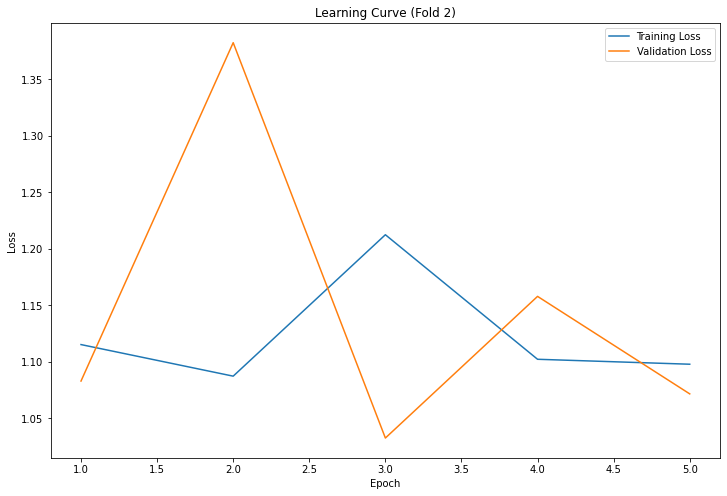

--------------DONE TRAINING MODEL FOR EarningsPerShareDiluted--------------




In [11]:
# Define variables
batch_size = 32
epochs=40
initial_lr=0.001
eps=1e-8
patience=5
cv=10
# Name metric
file = files[5]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(path + file)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Prepare dataset
dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

# Train model
best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset, 
                                                                                           epochs=epochs, initial_lr=initial_lr, 
                                                                                           eps=eps, cv=cv)  

# Save models
#If folder not available, create folder
if not os.path.exists('../models/finbert-regression/distilbert_data/' + metric_name):
   os.makedirs('../models/finbert-regression/distilbert_data/' + metric_name)
# Save model to folder
best_model_overall.save_pretrained('../models/finbert-regression/distilbert_data/' + metric_name) 

# Present results from the best model
print("Results from the best model")
print(f"Fold with best validation RSE: {best_fold_overall}")
print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 

plot_learning_curve(training_stats,best_fold_overall)
print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
print("\n")

### CV on all FinBERT data

#### NetCashProvidedByUsedInInvestingActivities - FinBERT

--------------START TRAINING MODEL FOR NetCashProvidedByUsedInInvestingActivities--------------
The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


Some weights of RegressionModel were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.6.output_layer_norm.weight', 'transformer.layer.1.attention.v_lin.weight', 'transformer.layer.9.ffn.lin2.weight', 'transformer.layer.1.attention.q_lin.bias', 'transformer.layer.11.ffn.lin1.weight', 'transformer.layer.7.attention.out_lin.bias', 'transformer.layer.5.ffn.lin2.weight', 'transformer.layer.7.ffn.lin1.bias', 'transformer.layer.9.output_layer_norm.weight', 'transformer.layer.6.attention.v_lin.weight', 'transformer.layer.9.attention.v_lin.weight', 'transformer.layer.9.attention.k_lin.weight', 'transformer.layer.11.attention.q_lin.weight', 'transformer.layer.8.ffn.lin2.bias', 'transformer.layer.11.attention.v_lin.bias', 'transformer.layer.5.attention.v_lin.bias', 'transformer.layer.5.attention.k_lin.weight', 'transformer.layer.5.attention.v_lin.weight', 'transformer.layer.7.ffn.lin2.weight', 'transformer.layer.9.sa_layer_no

Fold 1


  8%|▊         | 3/40 [00:02<00:24,  1.49it/s]


Early stopping at epoch 4 in fold 1
Fold 1 - Best Validation Loss: 1.9917547702789307 at Epoch: 1
Fold 2


  8%|▊         | 3/40 [00:02<00:24,  1.49it/s]


Early stopping at epoch 4 in fold 2
Fold 2 - Best Validation Loss: 2.5846774578094482 at Epoch: 1
Fold 3


  8%|▊         | 3/40 [00:02<00:24,  1.49it/s]


Early stopping at epoch 4 in fold 3
Fold 3 - Best Validation Loss: 2.0079195499420166 at Epoch: 1
Fold 4


  8%|▊         | 3/40 [00:01<00:24,  1.51it/s]


Early stopping at epoch 4 in fold 4
Fold 4 - Best Validation Loss: 4.623619556427002 at Epoch: 1
Fold 5


  8%|▊         | 3/40 [00:02<00:24,  1.50it/s]


Early stopping at epoch 4 in fold 5
Fold 5 - Best Validation Loss: 5.139918804168701 at Epoch: 1
Fold 6


  8%|▊         | 3/40 [00:02<00:24,  1.50it/s]


Early stopping at epoch 4 in fold 6
Fold 6 - Best Validation Loss: 6.057686805725098 at Epoch: 1
Fold 7


  8%|▊         | 3/40 [00:01<00:24,  1.50it/s]


Early stopping at epoch 4 in fold 7
Fold 7 - Best Validation Loss: 1.8174272775650024 at Epoch: 1
Fold 8


  8%|▊         | 3/40 [00:02<00:25,  1.45it/s]


Early stopping at epoch 4 in fold 8
Fold 8 - Best Validation Loss: 4.049647808074951 at Epoch: 1
Fold 9


  8%|▊         | 3/40 [00:02<00:25,  1.48it/s]


Early stopping at epoch 4 in fold 9
Fold 9 - Best Validation Loss: 2.590888738632202 at Epoch: 1
Fold 10


  8%|▊         | 3/40 [00:01<00:24,  1.51it/s]

Early stopping at epoch 4 in fold 10
Fold 10 - Best Validation Loss: 5.215689659118652 at Epoch: 1


Results from the best model
Fold with best validation RSE: 7
Best validation RSE: 1.82


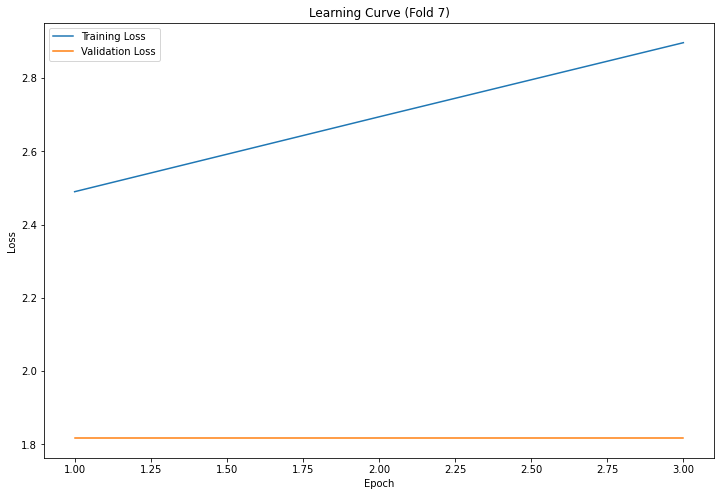

--------------DONE TRAINING MODEL FOR NetCashProvidedByUsedInInvestingActivities--------------




In [12]:
# Define variables
batch_size = 32
epochs=40
initial_lr=0.001
eps=1e-8
patience=5
cv=10


# Name metric
file = fb_files[0]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(fb_path + file)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Prepare dataset
dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

# Train model
best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset, 
                                                                                          epochs=epochs, initial_lr=initial_lr, 
                                                                                          eps=eps, cv=cv)  

# Save models
#If folder not available, create folder
if not os.path.exists('../models/finbert-regression/finbert_data/' + metric_name):
   os.makedirs('../models/finbert-regression/finbert_data/' + metric_name)
# Save model to folder
best_model_overall.save_pretrained('../models/finbert-regression/finbert_data/' + metric_name) 

# Present results from the best model
print("Results from the best model")
print(f"Fold with best validation RSE: {best_fold_overall}")
print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 

plot_learning_curve(training_stats,best_fold_overall)
print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
print("\n")

#### EBIT - FinBERT

--------------START TRAINING MODEL FOR EBIT--------------


Some weights of RegressionModel were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.6.output_layer_norm.weight', 'transformer.layer.1.attention.v_lin.weight', 'transformer.layer.9.ffn.lin2.weight', 'transformer.layer.1.attention.q_lin.bias', 'transformer.layer.11.ffn.lin1.weight', 'transformer.layer.7.attention.out_lin.bias', 'transformer.layer.5.ffn.lin2.weight', 'transformer.layer.7.ffn.lin1.bias', 'transformer.layer.9.output_layer_norm.weight', 'transformer.layer.6.attention.v_lin.weight', 'transformer.layer.9.attention.v_lin.weight', 'transformer.layer.9.attention.k_lin.weight', 'transformer.layer.11.attention.q_lin.weight', 'transformer.layer.8.ffn.lin2.bias', 'transformer.layer.11.attention.v_lin.bias', 'transformer.layer.5.attention.v_lin.bias', 'transformer.layer.5.attention.k_lin.weight', 'transformer.layer.5.attention.v_lin.weight', 'transformer.layer.7.ffn.lin2.weight', 'transformer.layer.9.sa_layer_no

Fold 1


  8%|▊         | 3/40 [00:12<02:31,  4.10s/it]


Early stopping at epoch 4 in fold 1
Fold 1 - Best Validation Loss: 3.6892329454421997 at Epoch: 1
Fold 2


  8%|▊         | 3/40 [00:12<02:33,  4.14s/it]


Early stopping at epoch 4 in fold 2
Fold 2 - Best Validation Loss: 2.4341732263565063 at Epoch: 1
Fold 3


  8%|▊         | 3/40 [00:12<02:32,  4.11s/it]


Early stopping at epoch 4 in fold 3
Fold 3 - Best Validation Loss: 2.086671769618988 at Epoch: 1
Fold 4


  8%|▊         | 3/40 [00:12<02:34,  4.18s/it]


Early stopping at epoch 4 in fold 4
Fold 4 - Best Validation Loss: 3.610517978668213 at Epoch: 1
Fold 5


  8%|▊         | 3/40 [00:12<02:35,  4.21s/it]


Early stopping at epoch 4 in fold 5
Fold 5 - Best Validation Loss: 1.834851861000061 at Epoch: 1
Fold 6


  8%|▊         | 3/40 [00:12<02:35,  4.20s/it]


Early stopping at epoch 4 in fold 6
Fold 6 - Best Validation Loss: 3.1807483434677124 at Epoch: 1
Fold 7


  8%|▊         | 3/40 [00:12<02:34,  4.17s/it]


Early stopping at epoch 4 in fold 7
Fold 7 - Best Validation Loss: 4.081070303916931 at Epoch: 1
Fold 8


  8%|▊         | 3/40 [00:12<02:34,  4.18s/it]


Early stopping at epoch 4 in fold 8
Fold 8 - Best Validation Loss: 13.7180814743042 at Epoch: 1
Fold 9


  8%|▊         | 3/40 [00:12<02:36,  4.23s/it]


Early stopping at epoch 4 in fold 9
Fold 9 - Best Validation Loss: 836.0017935037613 at Epoch: 1
Fold 10


  8%|▊         | 3/40 [00:12<02:35,  4.20s/it]

Early stopping at epoch 4 in fold 10
Fold 10 - Best Validation Loss: 1.9687251448631287 at Epoch: 1


Results from the best model
Fold with best validation RSE: 5
Best validation RSE: 1.83


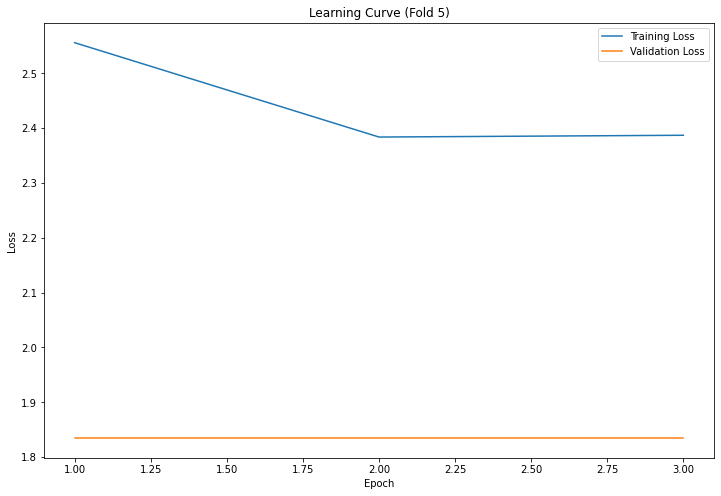

--------------DONE TRAINING MODEL FOR EBIT--------------




In [13]:
# Define variables
batch_size = 32
epochs=40
initial_lr=0.001
eps=1e-8
patience=5
cv=10


# Name metric
file = fb_files[1]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(fb_path + file)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Prepare dataset
dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

# Train model
best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset, 
                                                                                          epochs=epochs, initial_lr=initial_lr, 
                                                                                          eps=eps, cv=cv)  

# Save models
#If folder not available, create folder
if not os.path.exists('../models/finbert-regression/finbert_data/' + metric_name):
   os.makedirs('../models/finbert-regression/finbert_data/' + metric_name)
# Save model to folder
best_model_overall.save_pretrained('../models/finbert-regression/finbert_data/' + metric_name) 

# Present results from the best model
print("Results from the best model")
print(f"Fold with best validation RSE: {best_fold_overall}")
print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 

plot_learning_curve(training_stats,best_fold_overall)
print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
print("\n")

#### NetCashProvidedByUsedInFinancingActivities - FinBERT

--------------START TRAINING MODEL FOR NetCashProvidedByUsedInFinancingActivities--------------


Some weights of RegressionModel were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.6.output_layer_norm.weight', 'transformer.layer.1.attention.v_lin.weight', 'transformer.layer.9.ffn.lin2.weight', 'transformer.layer.1.attention.q_lin.bias', 'transformer.layer.11.ffn.lin1.weight', 'transformer.layer.7.attention.out_lin.bias', 'transformer.layer.5.ffn.lin2.weight', 'transformer.layer.7.ffn.lin1.bias', 'transformer.layer.9.output_layer_norm.weight', 'transformer.layer.6.attention.v_lin.weight', 'transformer.layer.9.attention.v_lin.weight', 'transformer.layer.9.attention.k_lin.weight', 'transformer.layer.11.attention.q_lin.weight', 'transformer.layer.8.ffn.lin2.bias', 'transformer.layer.11.attention.v_lin.bias', 'transformer.layer.5.attention.v_lin.bias', 'transformer.layer.5.attention.k_lin.weight', 'transformer.layer.5.attention.v_lin.weight', 'transformer.layer.7.ffn.lin2.weight', 'transformer.layer.9.sa_layer_no

Fold 1


  8%|▊         | 3/40 [00:01<00:14,  2.60it/s]


Early stopping at epoch 4 in fold 1
Fold 1 - Best Validation Loss: 3.529698610305786 at Epoch: 1
Fold 2


  8%|▊         | 3/40 [00:01<00:13,  2.75it/s]


Early stopping at epoch 4 in fold 2
Fold 2 - Best Validation Loss: 1.3939592838287354 at Epoch: 1
Fold 3


  8%|▊         | 3/40 [00:01<00:14,  2.49it/s]


Early stopping at epoch 4 in fold 3
Fold 3 - Best Validation Loss: 61.94618225097656 at Epoch: 1
Fold 4


  8%|▊         | 3/40 [00:01<00:13,  2.74it/s]


Early stopping at epoch 4 in fold 4
Fold 4 - Best Validation Loss: 93.9189682006836 at Epoch: 1
Fold 5


  8%|▊         | 3/40 [00:01<00:13,  2.73it/s]


Early stopping at epoch 4 in fold 5
Fold 5 - Best Validation Loss: 7.7790937423706055 at Epoch: 1
Fold 6


  8%|▊         | 3/40 [00:01<00:14,  2.58it/s]


Early stopping at epoch 4 in fold 6
Fold 6 - Best Validation Loss: 1.9174308776855469 at Epoch: 1
Fold 7


  5%|▌         | 2/40 [00:00<00:16,  2.37it/s]


Early stopping at epoch 3 in fold 7
Fold 7 - Best Validation Loss: inf at Epoch: 0
Fold 8


  5%|▌         | 2/40 [00:00<00:16,  2.28it/s]


Early stopping at epoch 3 in fold 8
Fold 8 - Best Validation Loss: inf at Epoch: 0
Fold 9


  5%|▌         | 2/40 [00:00<00:16,  2.26it/s]


Early stopping at epoch 3 in fold 9
Fold 9 - Best Validation Loss: inf at Epoch: 0
Fold 10


  5%|▌         | 2/40 [00:00<00:15,  2.40it/s]

Early stopping at epoch 3 in fold 10
Fold 10 - Best Validation Loss: inf at Epoch: 0


Results from the best model
Fold with best validation RSE: 2
Best validation RSE: 1.39


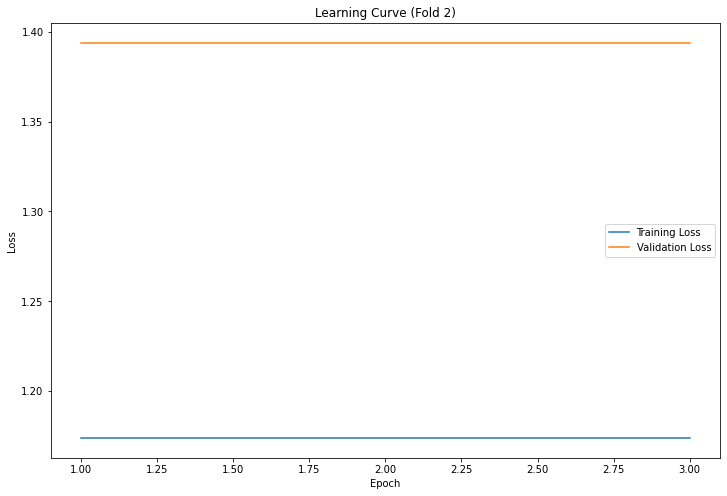

--------------DONE TRAINING MODEL FOR NetCashProvidedByUsedInFinancingActivities--------------




In [14]:
# Define variables
batch_size = 16
epochs=40
initial_lr=0.0001
eps=1e-8
patience=3
cv=10


# Name metric
file = fb_files[2]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(fb_path + file)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Prepare dataset
dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

# Train model
best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset, 
                                                                                          epochs=epochs, initial_lr=initial_lr, 
                                                                                          eps=eps, cv=cv)  

# Save models
#If folder not available, create folder
if not os.path.exists('../models/finbert-regression/finbert_data/' + metric_name):
   os.makedirs('../models/finbert-regression/finbert_data/' + metric_name)
# Save model to folder
best_model_overall.save_pretrained('../models/finbert-regression/finbert_data/' + metric_name) 

# Present results from the best model
print("Results from the best model")
print(f"Fold with best validation RSE: {best_fold_overall}")
print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 

plot_learning_curve(training_stats,best_fold_overall)
print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
print("\n")

#### Revenue - FinBERT

--------------START TRAINING MODEL FOR RevenueFromContractWithCustomerExcludingAssessedTax--------------


Some weights of RegressionModel were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.6.output_layer_norm.weight', 'transformer.layer.1.attention.v_lin.weight', 'transformer.layer.9.ffn.lin2.weight', 'transformer.layer.1.attention.q_lin.bias', 'transformer.layer.11.ffn.lin1.weight', 'transformer.layer.7.attention.out_lin.bias', 'transformer.layer.5.ffn.lin2.weight', 'transformer.layer.7.ffn.lin1.bias', 'transformer.layer.9.output_layer_norm.weight', 'transformer.layer.6.attention.v_lin.weight', 'transformer.layer.9.attention.v_lin.weight', 'transformer.layer.9.attention.k_lin.weight', 'transformer.layer.11.attention.q_lin.weight', 'transformer.layer.8.ffn.lin2.bias', 'transformer.layer.11.attention.v_lin.bias', 'transformer.layer.5.attention.v_lin.bias', 'transformer.layer.5.attention.k_lin.weight', 'transformer.layer.5.attention.v_lin.weight', 'transformer.layer.7.ffn.lin2.weight', 'transformer.layer.9.sa_layer_no

Fold 1


  8%|▊         | 3/40 [06:54<1:25:16, 138.27s/it]


Early stopping at epoch 4 in fold 1
Fold 1 - Best Validation Loss: 5.618078884482384 at Epoch: 1
Fold 2


  8%|▊         | 3/40 [06:52<1:24:49, 137.55s/it]


Early stopping at epoch 4 in fold 2
Fold 2 - Best Validation Loss: 3.002134236693382 at Epoch: 1
Fold 3


  8%|▊         | 3/40 [06:52<1:24:53, 137.66s/it]


Early stopping at epoch 4 in fold 3
Fold 3 - Best Validation Loss: 2.6199912250041963 at Epoch: 1
Fold 4


  8%|▊         | 3/40 [06:53<1:24:57, 137.77s/it]


Early stopping at epoch 4 in fold 4
Fold 4 - Best Validation Loss: 2.847772386670113 at Epoch: 1
Fold 5


  8%|▊         | 3/40 [06:52<1:24:47, 137.50s/it]


Early stopping at epoch 4 in fold 5
Fold 5 - Best Validation Loss: 2.499554294347763 at Epoch: 1
Fold 6


  5%|▌         | 2/40 [05:09<1:38:00, 154.75s/it]


Early stopping at epoch 3 in fold 6
Fold 6 - Best Validation Loss: inf at Epoch: 0
Fold 7


  5%|▌         | 2/40 [05:10<1:38:17, 155.19s/it]


Early stopping at epoch 3 in fold 7
Fold 7 - Best Validation Loss: inf at Epoch: 0
Fold 8


  5%|▌         | 2/40 [05:10<1:38:21, 155.29s/it]


Early stopping at epoch 3 in fold 8
Fold 8 - Best Validation Loss: inf at Epoch: 0
Fold 9


  5%|▌         | 2/40 [05:10<1:38:15, 155.15s/it]


Early stopping at epoch 3 in fold 9
Fold 9 - Best Validation Loss: inf at Epoch: 0
Fold 10


  5%|▌         | 2/40 [05:09<1:38:06, 154.92s/it]

Early stopping at epoch 3 in fold 10
Fold 10 - Best Validation Loss: inf at Epoch: 0


Results from the best model
Fold with best validation RSE: 5
Best validation RSE: 2.50


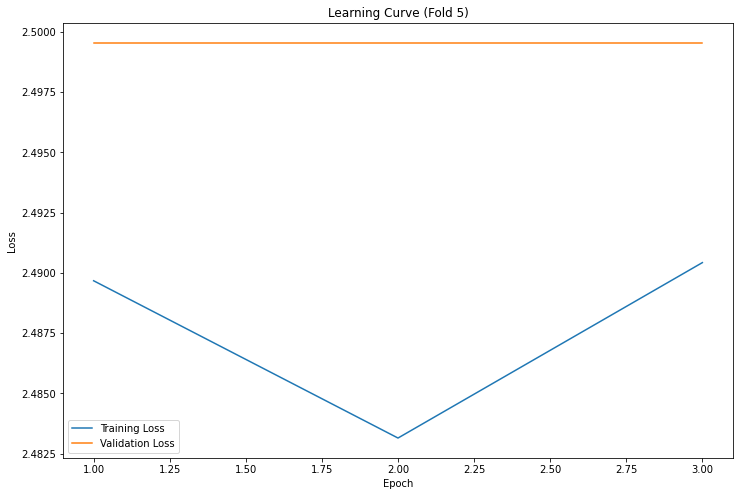

--------------DONE TRAINING MODEL FOR RevenueFromContractWithCustomerExcludingAssessedTax--------------




In [16]:
# Define variables
batch_size = 32
epochs=40
initial_lr=0.0001 # change to 0.0001 would be better because it will be more stable, 0.001 is too large
eps=1e-8
patience=5
cv=10


# Name metric
file = fb_files[3]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(fb_path + file)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Prepare dataset
dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

# Train model
best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset, 
                                                                                          epochs=epochs, initial_lr=initial_lr, 
                                                                                          eps=eps, cv=cv)  

# Save models
#If folder not available, create folder
if not os.path.exists('../models/finbert-regression/finbert_data/' + metric_name):
   os.makedirs('../models/finbert-regression/finbert_data/' + metric_name)
# Save model to folder
best_model_overall.save_pretrained('../models/finbert-regression/finbert_data/' + metric_name) 

# Present results from the best model
print("Results from the best model")
print(f"Fold with best validation RSE: {best_fold_overall}")
print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 

plot_learning_curve(training_stats,best_fold_overall)
print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
print("\n")

#### NetIncomeLoss - FinBERT

--------------START TRAINING MODEL FOR NetIncomeLoss--------------


Some weights of RegressionModel were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.5.sa_layer_norm.weight', 'transformer.layer.2.ffn.lin1.weight', 'transformer.layer.2.attention.k_lin.weight', 'transformer.layer.2.attention.out_lin.weight', 'transformer.layer.3.ffn.lin2.weight', 'transformer.layer.4.ffn.lin1.bias', 'transformer.layer.6.sa_layer_norm.weight', 'transformer.layer.10.sa_layer_norm.weight', 'transformer.layer.11.output_layer_norm.bias', 'transformer.layer.7.attention.k_lin.weight', 'transformer.layer.7.ffn.lin2.bias', 'embeddings.LayerNorm.weight', 'transformer.layer.11.attention.k_lin.bias', 'transformer.layer.2.sa_layer_norm.weight', 'transformer.layer.7.attention.q_lin.bias', 'transformer.layer.2.output_layer_norm.bias', 'transformer.layer.2.attention.q_lin.weight', 'transformer.layer.0.ffn.lin1.weight', 'transformer.layer.0.attention.k_lin.weight', 'transformer.layer.5.ffn.lin1.weight', 'transfor

Fold 1


 85%|████████▌ | 34/40 [1:29:57<15:52, 158.74s/it]


Early stopping at epoch 35 in fold 1
Fold 1 - Best Validation Loss: 2.292755805212876 at Epoch: 32
Fold 2


  8%|▊         | 3/40 [10:16<2:06:41, 205.45s/it]


Early stopping at epoch 4 in fold 2
Fold 2 - Best Validation Loss: 2.1105419294587495 at Epoch: 1
Fold 3


  8%|▊         | 3/40 [10:16<2:06:46, 205.58s/it]


Early stopping at epoch 4 in fold 3
Fold 3 - Best Validation Loss: 2.1032007994322943 at Epoch: 1
Fold 4


  8%|▊         | 3/40 [10:15<2:06:33, 205.23s/it]


Early stopping at epoch 4 in fold 4
Fold 4 - Best Validation Loss: 2.054242325240168 at Epoch: 1
Fold 5


 15%|█▌        | 6/40 [17:58<1:41:49, 179.70s/it]


Early stopping at epoch 7 in fold 5
Fold 5 - Best Validation Loss: 2.1207780529712807 at Epoch: 4
Fold 6


  8%|▊         | 3/40 [10:16<2:06:49, 205.67s/it]


Early stopping at epoch 4 in fold 6
Fold 6 - Best Validation Loss: 2.0890207023456178 at Epoch: 1
Fold 7


  8%|▊         | 3/40 [10:16<2:06:47, 205.62s/it]


Early stopping at epoch 4 in fold 7
Fold 7 - Best Validation Loss: 2.514253326531114 at Epoch: 1
Fold 8


  5%|▌         | 2/40 [07:41<2:26:12, 230.86s/it]


Early stopping at epoch 3 in fold 8
Fold 8 - Best Validation Loss: inf at Epoch: 0
Fold 9


  5%|▌         | 2/40 [07:42<2:26:36, 231.48s/it]


Early stopping at epoch 3 in fold 9
Fold 9 - Best Validation Loss: inf at Epoch: 0
Fold 10


  5%|▌         | 2/40 [07:42<2:26:25, 231.20s/it]

Early stopping at epoch 3 in fold 10
Fold 10 - Best Validation Loss: inf at Epoch: 0


Results from the best model
Fold with best validation RSE: 4
Best validation RSE: 2.05


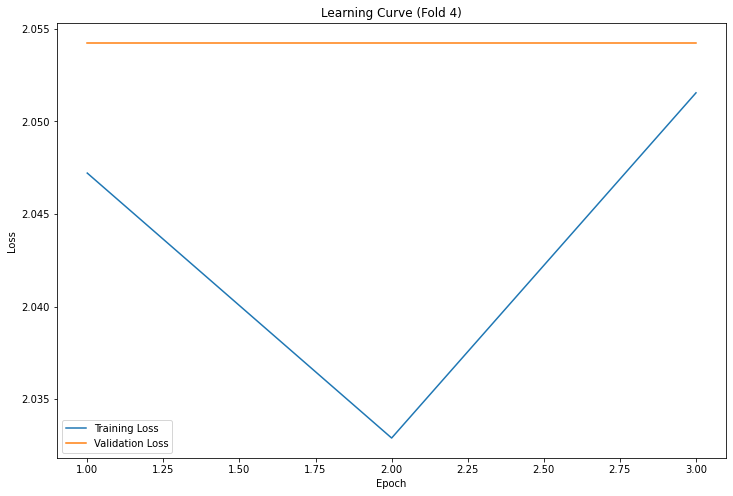

--------------DONE TRAINING MODEL FOR NetIncomeLoss--------------




In [16]:
# Define variables
batch_size = 32
epochs=40
initial_lr=0.001
eps=1e-8
patience=5
cv=10


# Name metric
file = fb_files[4]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(fb_path + file)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Prepare dataset
dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

# Train model
best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset, 
                                                                                          epochs=epochs, initial_lr=initial_lr, 
                                                                                          eps=eps, cv=cv)  

# Save models
#If folder not available, create folder
if not os.path.exists('../models/finbert-regression/finbert_data/' + metric_name):
   os.makedirs('../models/finbert-regression/finbert_data/' + metric_name)
# Save model to folder
best_model_overall.save_pretrained('../models/finbert-regression/finbert_data/' + metric_name) 

# Present results from the best model
print("Results from the best model")
print(f"Fold with best validation RSE: {best_fold_overall}")
print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 

plot_learning_curve(training_stats,best_fold_overall)
print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
print("\n")

#### EPS - FinBERT

--------------START TRAINING MODEL FOR EarningsPerShareDiluted--------------


Some weights of RegressionModel were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.5.sa_layer_norm.weight', 'transformer.layer.2.ffn.lin1.weight', 'transformer.layer.2.attention.k_lin.weight', 'transformer.layer.2.attention.out_lin.weight', 'transformer.layer.3.ffn.lin2.weight', 'transformer.layer.4.ffn.lin1.bias', 'transformer.layer.6.sa_layer_norm.weight', 'transformer.layer.10.sa_layer_norm.weight', 'transformer.layer.11.output_layer_norm.bias', 'transformer.layer.7.attention.k_lin.weight', 'transformer.layer.7.ffn.lin2.bias', 'embeddings.LayerNorm.weight', 'transformer.layer.11.attention.k_lin.bias', 'transformer.layer.2.sa_layer_norm.weight', 'transformer.layer.7.attention.q_lin.bias', 'transformer.layer.2.output_layer_norm.bias', 'transformer.layer.2.attention.q_lin.weight', 'transformer.layer.0.ffn.lin1.weight', 'transformer.layer.0.attention.k_lin.weight', 'transformer.layer.5.ffn.lin1.weight', 'transfor

Fold 1


 25%|██▌       | 10/40 [01:05<03:17,  6.58s/it]


Early stopping at epoch 11 in fold 1
Fold 1 - Best Validation Loss: 1.1112149159113567 at Epoch: 8
Fold 2


  8%|▊         | 3/40 [00:23<04:55,  7.98s/it]


Early stopping at epoch 4 in fold 2
Fold 2 - Best Validation Loss: 1.10459299882253 at Epoch: 1
Fold 3


  8%|▊         | 3/40 [00:23<04:55,  7.99s/it]


Early stopping at epoch 4 in fold 3
Fold 3 - Best Validation Loss: 1.4428151448567708 at Epoch: 1
Fold 4


 15%|█▌        | 6/40 [00:41<03:57,  6.97s/it]


Early stopping at epoch 7 in fold 4
Fold 4 - Best Validation Loss: 1.5449285507202148 at Epoch: 4
Fold 5


  8%|▊         | 3/40 [00:23<04:55,  7.99s/it]


Early stopping at epoch 4 in fold 5
Fold 5 - Best Validation Loss: 1.1354157129923503 at Epoch: 1
Fold 6


  8%|▊         | 3/40 [00:23<04:55,  7.98s/it]


Early stopping at epoch 4 in fold 6
Fold 6 - Best Validation Loss: 1.329614241917928 at Epoch: 1
Fold 7


 10%|█         | 4/40 [00:29<04:28,  7.46s/it]


Early stopping at epoch 5 in fold 7
Fold 7 - Best Validation Loss: 1.6806857585906982 at Epoch: 2
Fold 8


  8%|▊         | 3/40 [00:23<04:54,  7.95s/it]


Early stopping at epoch 4 in fold 8
Fold 8 - Best Validation Loss: 1.0744662682215373 at Epoch: 1
Fold 9


 15%|█▌        | 6/40 [00:41<03:56,  6.97s/it]


Early stopping at epoch 7 in fold 9
Fold 9 - Best Validation Loss: 1.2045284509658813 at Epoch: 4
Fold 10


 10%|█         | 4/40 [00:29<04:29,  7.50s/it]

Early stopping at epoch 5 in fold 10
Fold 10 - Best Validation Loss: 1.0555521249771118 at Epoch: 2


Results from the best model
Fold with best validation RSE: 10
Best validation RSE: 1.06


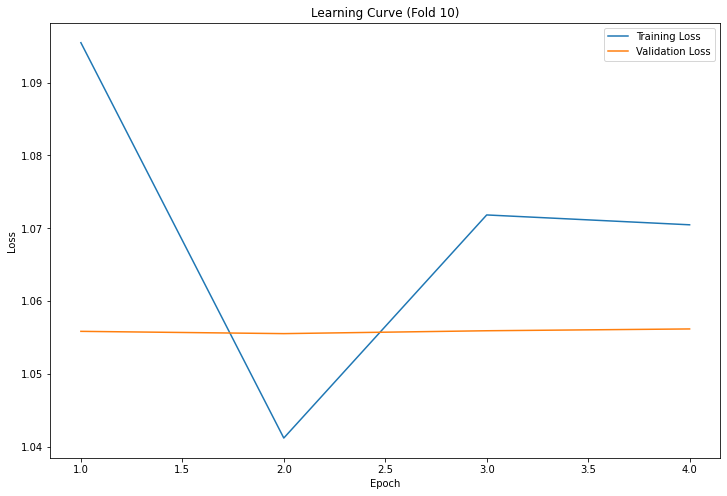

--------------DONE TRAINING MODEL FOR EarningsPerShareDiluted--------------




In [15]:
# Define variables
batch_size = 16
epochs=40
initial_lr=0.0001
eps=1e-8
patience=5
cv=10


# Name metric
file = fb_files[5]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(fb_path + file)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Prepare dataset
dataset = prepare_labeled_datasets(tokenizer, model, 300, df['text'].values.tolist(), df['target'].values.tolist()) 

# Train model
best_model_overall, best_val_loss_overall, best_fold_overall, all_train_losses, all_val_losses, training_stats  = train_finbert_regressor(model, tokenizer, dataset, 
                                                                                          epochs=epochs, initial_lr=initial_lr, 
                                                                                          eps=eps, cv=cv)  

# Save models
#If folder not available, create folder
if not os.path.exists('../models/finbert-regression/finbert_data/' + metric_name):
   os.makedirs('../models/finbert-regression/finbert_data/' + metric_name)
# Save model to folder
best_model_overall.save_pretrained('../models/finbert-regression/finbert_data/' + metric_name) 

# Present results from the best model
print("Results from the best model")
print(f"Fold with best validation RSE: {best_fold_overall}")
print("Best validation RSE: {0:.2f}".format(best_val_loss_overall)) 

plot_learning_curve(training_stats,best_fold_overall)
print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
print("\n")

In [9]:
# Plot the learning curve
def plot_learning_curve(train_losses, val_losses):
    plt.figure(figsize=(15, 8))
    plt.title("Training vs. Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(train_losses, 'b-o', label="Training Loss")
    plt.plot(val_losses, 'r-o', label="Validation loss")
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

## NetCashProvidedByUsedInInvestingActivities

--------------START TRAINING MODEL FOR NetCashProvidedByUsedInInvestingActivities--------------


Some weights of RegressionModel were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.6.output_layer_norm.weight', 'transformer.layer.11.output_layer_norm.bias', 'transformer.layer.4.ffn.lin2.bias', 'transformer.layer.9.attention.q_lin.bias', 'transformer.layer.9.attention.k_lin.weight', 'transformer.layer.8.sa_layer_norm.bias', 'transformer.layer.2.sa_layer_norm.bias', 'transformer.layer.0.ffn.lin1.bias', 'transformer.layer.1.sa_layer_norm.bias', 'transformer.layer.3.ffn.lin2.bias', 'transformer.layer.3.attention.k_lin.bias', 'transformer.layer.7.sa_layer_norm.weight', 'transformer.layer.6.attention.q_lin.bias', 'transformer.layer.5.attention.k_lin.weight', 'transformer.layer.0.ffn.lin1.weight', 'transformer.layer.3.sa_layer_norm.bias', 'transformer.layer.8.ffn.lin1.weight', 'transformer.layer.4.attention.out_lin.weight', 'transformer.layer.2.attention.v_lin.bias', 'transformer.layer.6.attention.k_lin.weight', 'tr

       Training Loss  Valid. Loss  Training Time  Learning Rate
Epoch                                                          
1           2.260489     6.259051       0.476233       0.000900
2           2.538812     6.259051       0.456222       0.000810
3           2.503164     6.259051       0.455377       0.000729
4           2.276311     6.259052       0.455490       0.000656
5           2.294718     6.259051       0.456920       0.000590
6           2.242050     6.259051       0.454749       0.000531
7           2.457535     6.259051       0.457343       0.000478
8           2.207924     6.259051       0.456136       0.000430
9           2.220384     6.259051       0.457397       0.000387
10          2.198610     6.259050       0.458976       0.000349
11          2.377462     6.259051       0.455616       0.000314
12          2.316558     6.259050       0.455820       0.000282
13          2.693615     6.259050       0.455049       0.000254
14          2.327534     6.259050       

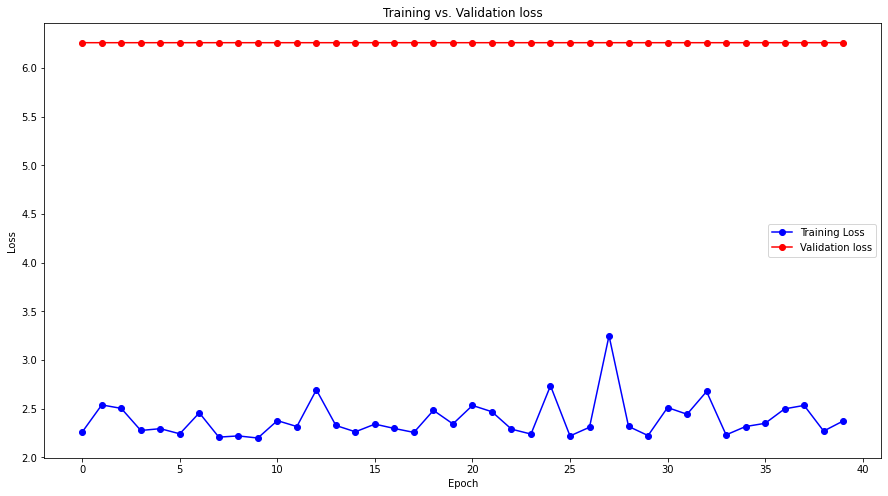

--------------DONE TRAINING MODEL FOR NetCashProvidedByUsedInInvestingActivities--------------




In [48]:
# Define variables
batch_size = 16
epochs=40
initial_lr=0.001
eps=1e-8
# Name metric
file = files[0]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(path + file)

# Train validation split
train_df, val_df = train_val_split(df, test_size=0.2)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Prepare datasets
train_dataset = prepare_labeled_datasets(tokenizer, model, 300, train_df['text'].values, train_df['target'].values)
val_dataset = prepare_labeled_datasets(tokenizer, model, 300, val_df['text'].values, val_df['target'].values)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Train model
best_model, train_losses, val_losses, best_epoch, best_val_loss  = train_finbert_regressor(model, tokenizer, train_dataloader, val_dataloader, epochs=epochs, initial_lr=initial_lr, eps=eps)

# Save models
# If folder not available, create folder
if not os.path.exists('../models/finbert-regression/' + metric_name):
    os.makedirs('../models/finbert-regression/' + metric_name)
# Save model to folder
best_model.save_pretrained('../models/finbert-regression/' + metric_name)   

    
# Present results from the best model
print("    Results from the best model")
print(f"Epoch with best validation RSE: {best_epoch}")
print("Best validation RSE: {0:.2f}".format(best_val_loss)) 

plot_learning_curve(train_losses, val_losses)
print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
print("\n")

## EBIT

In [13]:
files[1]

'EBIT_train__text_clean.csv'

--------------START TRAINING MODEL FOR EBIT--------------


Some weights of RegressionModel were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.6.output_layer_norm.weight', 'transformer.layer.11.output_layer_norm.bias', 'transformer.layer.4.ffn.lin2.bias', 'transformer.layer.9.attention.q_lin.bias', 'transformer.layer.9.attention.k_lin.weight', 'transformer.layer.8.sa_layer_norm.bias', 'transformer.layer.2.sa_layer_norm.bias', 'transformer.layer.0.ffn.lin1.bias', 'transformer.layer.1.sa_layer_norm.bias', 'transformer.layer.3.ffn.lin2.bias', 'transformer.layer.3.attention.k_lin.bias', 'transformer.layer.7.sa_layer_norm.weight', 'transformer.layer.6.attention.q_lin.bias', 'transformer.layer.5.attention.k_lin.weight', 'transformer.layer.0.ffn.lin1.weight', 'transformer.layer.3.sa_layer_norm.bias', 'transformer.layer.8.ffn.lin1.weight', 'transformer.layer.4.attention.out_lin.weight', 'transformer.layer.2.attention.v_lin.bias', 'transformer.layer.6.attention.k_lin.weight', 'tr

       Training Loss  Valid. Loss  Training Time  Learning Rate
Epoch                                                          
1       5.109443e+00     2.491241       2.706523       0.000090
2       4.803017e+00     2.491241       2.684212       0.000081
3       3.326144e+00     2.491241       2.688106       0.000073
4       2.021902e+00     2.491241       2.692619       0.000066
5       2.262008e+00     2.491241       2.701118       0.000059
6       1.919093e+00     2.491241       2.703485       0.000053
7       1.314381e+01     2.491241       2.707694       0.000048
8       1.407100e+02     2.491241       2.707234       0.000043
9       5.435160e+00     2.491241       2.705634       0.000039
10      2.080898e+00     2.491241       2.712907       0.000035
11      2.828998e+00     2.491241       2.709030       0.000031
12      2.084303e+03     2.491241       2.709532       0.000028
13      2.348060e+06     2.491241       2.714065       0.000025
14      2.898756e+00     2.491241       

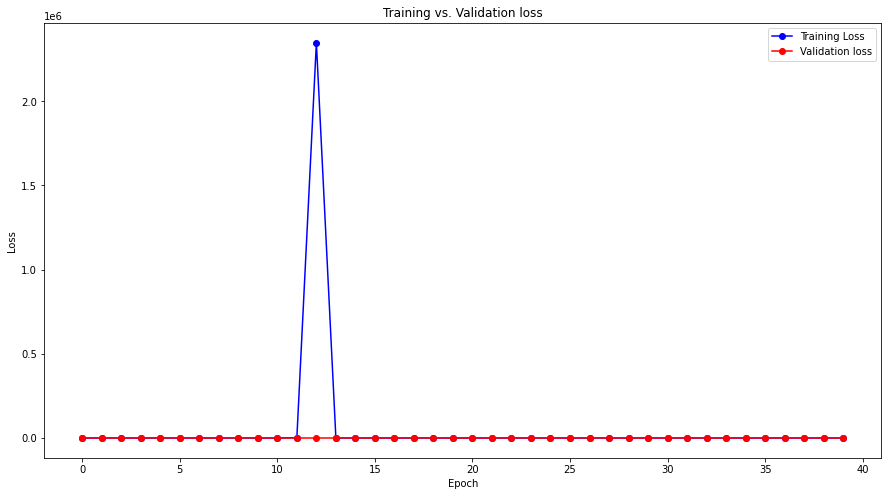

--------------DONE TRAINING MODEL FOR EBIT--------------




In [50]:
# Define variables
batch_size = 16
epochs=40
initial_lr=0.0001
eps=1e-8
# Name metric
file = files[1]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(path + file)

# Train validation split
train_df, val_df = train_val_split(df, test_size=0.2)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Prepare datasets
train_dataset = prepare_labeled_datasets(tokenizer, model, 300, train_df['text'].values, train_df['target'].values)
val_dataset = prepare_labeled_datasets(tokenizer, model, 300, val_df['text'].values, val_df['target'].values)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Train model
best_model, train_losses, val_losses, best_epoch, best_val_loss  = train_finbert_regressor(model, tokenizer, train_dataloader, val_dataloader, epochs=epochs, initial_lr=initial_lr, eps=eps)

# Save models
# If folder not available, create folder
if not os.path.exists('../models/finbert-regression/' + metric_name):
    os.makedirs('../models/finbert-regression/' + metric_name)
# Save model to folder
best_model.save_pretrained('../models/finbert-regression/' + metric_name)   

    
# Present results from the best model
print("    Results from the best model")
print(f"Epoch with best validation RSE: {best_epoch}")
print("Best validation RSE: {0:.2f}".format(best_val_loss)) 

plot_learning_curve(train_losses, val_losses)
print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
print("\n")

## NetCashProvidedByUsedInFinancingActivities

--------------START TRAINING MODEL FOR NetCashProvidedByUsedInFinancingActivities--------------


Some weights of RegressionModel were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.6.output_layer_norm.weight', 'transformer.layer.11.output_layer_norm.bias', 'transformer.layer.4.ffn.lin2.bias', 'transformer.layer.9.attention.q_lin.bias', 'transformer.layer.9.attention.k_lin.weight', 'transformer.layer.8.sa_layer_norm.bias', 'transformer.layer.2.sa_layer_norm.bias', 'transformer.layer.0.ffn.lin1.bias', 'transformer.layer.1.sa_layer_norm.bias', 'transformer.layer.3.ffn.lin2.bias', 'transformer.layer.3.attention.k_lin.bias', 'transformer.layer.7.sa_layer_norm.weight', 'transformer.layer.6.attention.q_lin.bias', 'transformer.layer.5.attention.k_lin.weight', 'transformer.layer.0.ffn.lin1.weight', 'transformer.layer.3.sa_layer_norm.bias', 'transformer.layer.8.ffn.lin1.weight', 'transformer.layer.4.attention.out_lin.weight', 'transformer.layer.2.attention.v_lin.bias', 'transformer.layer.6.attention.k_lin.weight', 'tr

       Training Loss  Valid. Loss  Training Time  Learning Rate
Epoch                                                          
1           1.256264     1.637461       0.302599        0.00009
2           1.256264     1.637461       0.285897        0.00009
3           1.256264     1.637461       0.282401        0.00009
4           1.256264     1.637461       0.286563        0.00009
5           1.256264     1.637461       0.285022        0.00009
6           1.256264     1.637461       0.285423        0.00009
7           1.256264     1.637461       0.285537        0.00009
8           1.256264     1.637461       0.284576        0.00009
9           1.256264     1.637461       0.291295        0.00009
10          1.256264     1.637461       0.284820        0.00009
11          1.256264     1.637461       0.287927        0.00009
12          1.256264     1.637461       0.286223        0.00009
13          1.256264     1.637461       0.283401        0.00009
14          1.256264     1.637461       

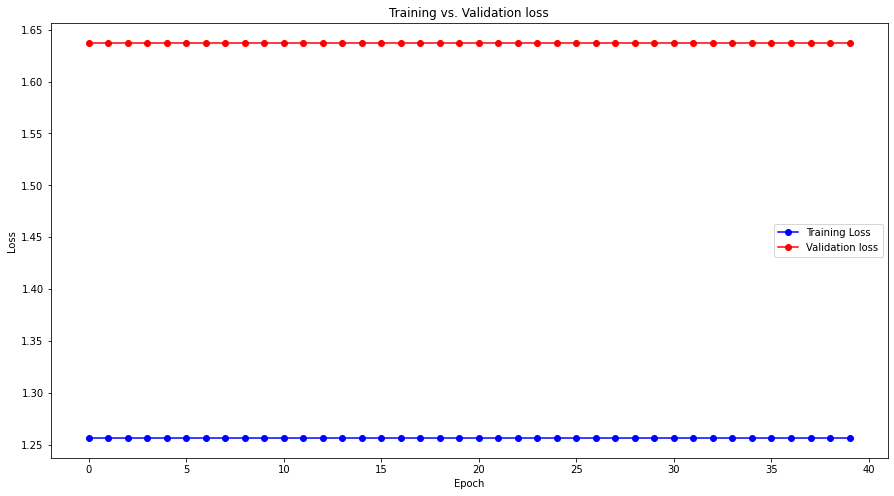

--------------DONE TRAINING MODEL FOR NetCashProvidedByUsedInFinancingActivities--------------




In [42]:
# Define variables
batch_size = 16
epochs=40
initial_lr=0.0001
eps=1e-8
# Name metric
file = files[2]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(path + file)

# Train validation split
train_df, val_df = train_val_split(df, test_size=0.2)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Prepare datasets
train_dataset = prepare_labeled_datasets(tokenizer, model, 300, train_df['text'].values, train_df['target'].values)
val_dataset = prepare_labeled_datasets(tokenizer, model, 300, val_df['text'].values, val_df['target'].values)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Train model
best_model, train_losses, val_losses, best_epoch, best_val_loss  = train_finbert_regressor(model, tokenizer, train_dataloader, val_dataloader, epochs=epochs, initial_lr=initial_lr, eps=eps)

# Save models
# If folder not available, create folder
if not os.path.exists('../models/finbert-regression/' + metric_name):
    os.makedirs('../models/finbert-regression/' + metric_name)
# Save model to folder
best_model.save_pretrained('../models/finbert-regression/' + metric_name)   

    
# Present results from the best model
print("    Results from the best model")
print(f"Epoch with best validation RSE: {best_epoch}")
print("Best validation RSE: {0:.2f}".format(best_val_loss)) 

plot_learning_curve(train_losses, val_losses)
print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
print("\n")

## Revenue

--------------START TRAINING MODEL FOR RevenueFromContractWithCustomerExcludingAssessedTax--------------


Some weights of RegressionModel were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.6.output_layer_norm.weight', 'transformer.layer.11.output_layer_norm.bias', 'transformer.layer.4.ffn.lin2.bias', 'transformer.layer.9.attention.q_lin.bias', 'transformer.layer.9.attention.k_lin.weight', 'transformer.layer.8.sa_layer_norm.bias', 'transformer.layer.2.sa_layer_norm.bias', 'transformer.layer.0.ffn.lin1.bias', 'transformer.layer.1.sa_layer_norm.bias', 'transformer.layer.3.ffn.lin2.bias', 'transformer.layer.3.attention.k_lin.bias', 'transformer.layer.7.sa_layer_norm.weight', 'transformer.layer.6.attention.q_lin.bias', 'transformer.layer.5.attention.k_lin.weight', 'transformer.layer.0.ffn.lin1.weight', 'transformer.layer.3.sa_layer_norm.bias', 'transformer.layer.8.ffn.lin1.weight', 'transformer.layer.4.attention.out_lin.weight', 'transformer.layer.2.attention.v_lin.bias', 'transformer.layer.6.attention.k_lin.weight', 'tr

       Training Loss  Valid. Loss  Training Time  Learning Rate
Epoch                                                          
1           2.305572     2.451944      85.839201       0.000081
2           2.318070     2.451944      86.208444       0.000081
3           2.331498     2.451944      85.954415       0.000081
4           2.314704     2.451944      85.745896       0.000081
5           2.309715     2.451944      85.792531       0.000081
6           2.319374     2.451944      85.768324       0.000081
7           2.300891     2.451944      85.625448       0.000081
8           2.304328     2.451944      85.596821       0.000081
9           2.312352     2.451944      85.651890       0.000081
10          2.316868     2.451944      85.743462       0.000081
11          2.309696     2.451944      85.656377       0.000081
12          2.316662     2.451944      85.614292       0.000081
13          2.325940     2.451944      85.625920       0.000081
14          2.320548     2.451944      8

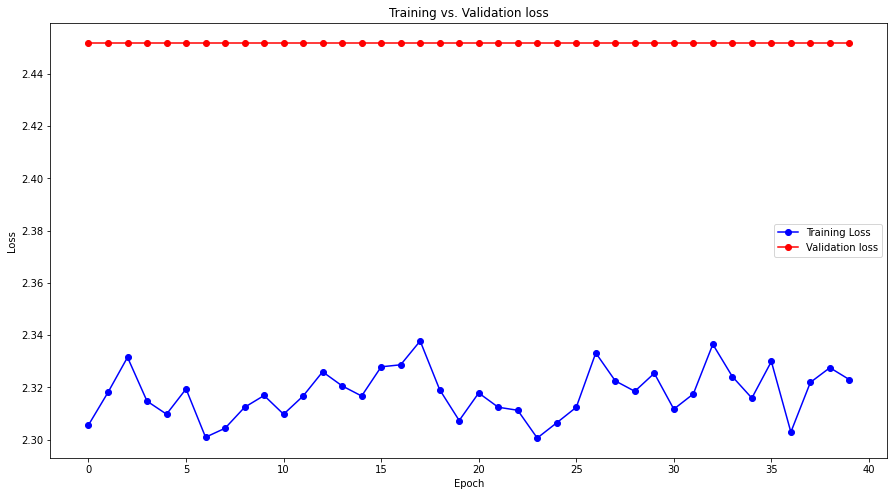

--------------DONE TRAINING MODEL FOR RevenueFromContractWithCustomerExcludingAssessedTax--------------




In [44]:
# Define variables
batch_size = 32
epochs=40
initial_lr=0.0001
eps=1e-8
# Name metric
file = files[3]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(path + file)

# Train validation split
train_df, val_df = train_val_split(df, test_size=0.2)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Prepare datasets
train_dataset = prepare_labeled_datasets(tokenizer, model, 300, train_df['text'].values, train_df['target'].values)
val_dataset = prepare_labeled_datasets(tokenizer, model, 300, val_df['text'].values, val_df['target'].values)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Train model
best_model, train_losses, val_losses, best_epoch, best_val_loss  = train_finbert_regressor(model, tokenizer, train_dataloader, val_dataloader, epochs=epochs, initial_lr=initial_lr, eps=eps)

# Save models
# If folder not available, create folder
if not os.path.exists('../models/finbert-regression/' + metric_name):
    os.makedirs('../models/finbert-regression/' + metric_name)
# Save model to folder
best_model.save_pretrained('../models/finbert-regression/' + metric_name)   

    
# Present results from the best model
print("    Results from the best model")
print(f"Epoch with best validation RSE: {best_epoch}")
print("Best validation RSE: {0:.2f}".format(best_val_loss)) 

plot_learning_curve(train_losses, val_losses)
print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
print("\n")

## NetIncomeLoss

In [20]:
# Define variables
batch_size = 16
epochs=40
lr=2e-5
eps=1e-8
# Name metric
file = files[4]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(path + file)

# Train validation split
train_df, val_df = train_val_split(df, test_size=0.2)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Prepare datasets
train_dataset = prepare_labeled_datasets(tokenizer, model, 512, train_df['text'].values, train_df['target'].values)
val_dataset = prepare_labeled_datasets(tokenizer, model, 512, val_df['text'].values, val_df['target'].values)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Train model
best_model, train_losses, val_losses, best_epoch, best_val_loss  = train_finbert_regressor(model, tokenizer, train_dataloader, val_dataloader, epochs=epochs, lr=lr, eps=eps)

# Save models
# If folder not available, create folder
if not os.path.exists('../models/finbert-regression/' + metric_name):
    os.makedirs('../models/finbert-regression/' + metric_name)
# Save model to folder
best_model.save_pretrained('../models/finbert-regression/' + metric_name)   

    
# Present results from the best model
print("    Results from the best model")
print(f"Epoch with best validation RSE: {best_epoch}")
print("Best validation RSE: {0:.2f}".format(best_val_loss)) 

plot_learning_curve(train_losses, val_losses)
print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
print("\n")

--------------START TRAINING MODEL FOR NetIncomeLoss--------------


Some weights of RegressionModel were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.6.output_layer_norm.weight', 'transformer.layer.11.output_layer_norm.bias', 'transformer.layer.4.ffn.lin2.bias', 'transformer.layer.9.attention.q_lin.bias', 'transformer.layer.9.attention.k_lin.weight', 'transformer.layer.8.sa_layer_norm.bias', 'transformer.layer.2.sa_layer_norm.bias', 'transformer.layer.0.ffn.lin1.bias', 'transformer.layer.1.sa_layer_norm.bias', 'transformer.layer.3.ffn.lin2.bias', 'transformer.layer.3.attention.k_lin.bias', 'transformer.layer.7.sa_layer_norm.weight', 'transformer.layer.6.attention.q_lin.bias', 'transformer.layer.5.attention.k_lin.weight', 'transformer.layer.0.ffn.lin1.weight', 'transformer.layer.3.sa_layer_norm.bias', 'transformer.layer.8.ffn.lin1.weight', 'transformer.layer.4.attention.out_lin.weight', 'transformer.layer.2.attention.v_lin.bias', 'transformer.layer.6.attention.k_lin.weight', 'tr

KeyboardInterrupt: 

In [ ]:
# Define variables
batch_size = 16
epochs=40
lr=2e-5
eps=1e-8
# Name metric
file = files[5]
metric_name = file.split('.')[0].split('_')[0]

print(f"--------------START TRAINING MODEL FOR {metric_name}--------------")

# Read csv file
df = pd.read_csv(path + file)

# Train validation split
train_df, val_df = train_val_split(df, test_size=0.2)

# Load model and tokenizer
model, tokenizer = finbert_regressor()
model.to(device)

# Prepare datasets
train_dataset = prepare_labeled_datasets(tokenizer, model, 512, train_df['text'].values, train_df['target'].values)
val_dataset = prepare_labeled_datasets(tokenizer, model, 512, val_df['text'].values, val_df['target'].values)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Train model
best_model, train_losses, val_losses, best_epoch, best_val_loss  = train_finbert_regressor(model, tokenizer, train_dataloader, val_dataloader, epochs=epochs, lr=lr, eps=eps)

# Save models
# If folder not available, create folder
if not os.path.exists('../models/finbert-regression/' + metric_name):
    os.makedirs('../models/finbert-regression/' + metric_name)
# Save model to folder
best_model.save_pretrained('../models/finbert-regression/' + metric_name)   

    
# Present results from the best model
print("    Results from the best model")
print(f"Epoch with best validation RSE: {best_epoch}")
print("Best validation RSE: {0:.2f}".format(best_val_loss)) 

plot_learning_curve(train_losses, val_losses)
print(f"--------------DONE TRAINING MODEL FOR {metric_name}--------------")
print("\n")

In [34]:
files[0].split('.')[0].split('_')[0]  

'NetCashProvidedByUsedInInvestingActivities'

epoch:  1
Training...


100%|██████████| 18/18 [00:04<00:00,  3.77it/s]



summary results
epoch | train loss | train time
    1 | 0.22744 |  4.77855372428894

Running Validation...


100%|██████████| 5/5 [00:00<00:00, 13.03it/s]


  Validation loss: 1.03
  BEST MODEL SO FAR! SAVING IT...
epoch:  2
Training...


100%|██████████| 18/18 [00:04<00:00,  3.84it/s]



summary results
epoch | train loss | train time
    2 | 0.21833 |  4.685414552688599

Running Validation...


100%|██████████| 5/5 [00:00<00:00, 12.95it/s]


  Validation loss: 1.05
epoch:  3
Training...


100%|██████████| 18/18 [00:04<00:00,  3.84it/s]



summary results
epoch | train loss | train time
    3 | 0.19609 |  4.693521976470947

Running Validation...


100%|██████████| 5/5 [00:00<00:00, 12.95it/s]


  Validation loss: 1.14
epoch:  4
Training...


100%|██████████| 18/18 [00:04<00:00,  3.83it/s]



summary results
epoch | train loss | train time
    4 | 0.18973 |  4.698243618011475

Running Validation...


100%|██████████| 5/5 [00:00<00:00, 12.91it/s]


  Validation loss: 1.23
epoch:  5
Training...


100%|██████████| 18/18 [00:04<00:00,  3.83it/s]



summary results
epoch | train loss | train time
    5 | 0.17927 |  4.708595275878906

Running Validation...


100%|██████████| 5/5 [00:00<00:00, 12.89it/s]


  Validation loss: 1.06
epoch:  6
Training...


100%|██████████| 18/18 [00:04<00:00,  3.81it/s]



summary results
epoch | train loss | train time
    6 | 0.22321 |  4.721346378326416

Running Validation...


100%|██████████| 5/5 [00:00<00:00, 12.88it/s]


  Validation loss: 0.87
  BEST MODEL SO FAR! SAVING IT...
epoch:  7
Training...


100%|██████████| 18/18 [00:04<00:00,  3.81it/s]



summary results
epoch | train loss | train time
    7 | 0.17763 |  4.725480079650879

Running Validation...


100%|██████████| 5/5 [00:00<00:00, 12.88it/s]


  Validation loss: 1.02
epoch:  8
Training...


100%|██████████| 18/18 [00:04<00:00,  3.80it/s]



summary results
epoch | train loss | train time
    8 | 0.18214 |  4.744260549545288

Running Validation...


100%|██████████| 5/5 [00:00<00:00, 12.81it/s]


  Validation loss: 0.95
epoch:  9
Training...


100%|██████████| 18/18 [00:04<00:00,  3.80it/s]



summary results
epoch | train loss | train time
    9 | 0.20480 |  4.741695404052734

Running Validation...


100%|██████████| 5/5 [00:00<00:00, 12.83it/s]


  Validation loss: 1.04
epoch:  10
Training...


100%|██████████| 18/18 [00:04<00:00,  3.79it/s]



summary results
epoch | train loss | train time
   10 | 0.18151 |  4.749243259429932

Running Validation...


100%|██████████| 5/5 [00:00<00:00, 12.84it/s]

  Validation loss: 0.93


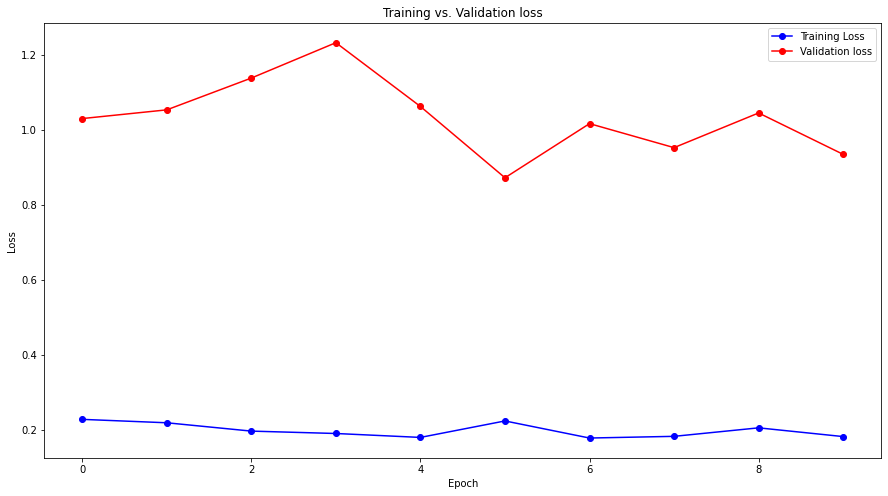

Epoch with best validation RSE: 7
Best validation RSE: 0.87


In [38]:
# Initialize the best validation RSE 
best_validation_rse = float('inf') # set to infinity

model.to(device) # send the model to GPU
model.train() # switch to train mode i.e. forward, backward, optimization
optimizer = AdamW(model.parameters(), lr=5e-5) # choose an optimizer for the gradient descent
loss_values = [] # accumulate training losses for plotting
eval_loss_values = [] # accumulate validation losses for plotting

# define number of epochs
epochs = 10
for epoch in range(epochs): #number of epochs i.e. how many times is the whole dataset passed through the architecture
      # =================================
      #              Training
      # =================================
      
      print("epoch: ", epoch+1)
      #print("Training...")
      # capture time
      total_t0 = time.time()
      train_total_loss = 0
      for batch in tqdm(train_dataloader): # split into batches to fit into the memory
            input_ids, labels = batch
            input_ids.to(device)
            labels.to(device)
            
            # Always clear any previously calculated gradients before performing a
            # backward pass. 
            optimizer.zero_grad()

            # Perform a forward pass (evaluate the model on this training batch).
            # This will return the loss (rather than the model output) because we
            # have provided the `labels`.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(input_ids,labels=labels)
            # Calculate the loss i.e. distance between predicted labels and true labels using cross entropy
            loss = outputs[0]

            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value 
            # from the tensor.
            train_total_loss += loss.item()
            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters using the optimizer and the gradient values
            optimizer.step()
      
      # print result summaries
      #print("")
      #print("summary results")
      #print("epoch | train loss | train time")
      # Calculate the average loss over the training data.
      avg_train_loss = train_total_loss / len(train_dataloader)
      
      # Store the loss value for plotting the learning curve.
      loss_values.append(avg_train_loss)
      
      
      # training time end
      training_time = time.time() - total_t0
      #print(f"{epoch+1:5d} | {avg_train_loss:.5f} |  {training_time:}")
      
      # =================================
      #             Validation
      # =================================
      # After the completion of each training epoch, measure our performance on
      # our validation set.
      print("")
      #print("Running Validation...")
      # capture time
      total_t0 = time.time()
      # switch to evaluation mode i.e. no backward pass
      model.eval()
      with torch.no_grad():
            preds_list = []
            labels_list = []
            rse_list = []
            
            rse_sum = 0

            for batch in tqdm(val_dataloader):
                  input_ids, labels = batch
                  input_ids.to(device)
                  labels.to(device)

                  outputs = model(input_ids=input_ids, labels=labels)
                  loss = outputs[0] # Access the loss from the outputs tuple
            
                  # Predictions from the model
                  preds = outputs[1]  # The predicted values are the second element of the tuple outputted by the model
                  preds_list.extend(preds.cpu().numpy())
                  labels_list.extend(labels.cpu().numpy())

                  # Calculate RSE
                  mse_predictions_labels = torch.nn.functional.mse_loss(preds[:, 0], labels.float()).item()
                  mean_labels = torch.mean(labels.float())
                  mse_labels_mean = torch.nn.functional.mse_loss(labels.float(), mean_labels.expand_as(labels)).item()
                  rse = mse_predictions_labels / mse_labels_mean
                  rse_list.append(rse)
                  rse_sum += rse

            mean_rse = rse_sum / len(val_dataloader)
            #print("  Validation loss: {0:.2f}".format(mean_rse))
            
            # Store the loss value for plotting the learning curve.
            eval_loss_values.append(mean_rse)
            
            # Check if the current model is the best one and save it.
            if mean_rse < best_validation_rse:
                  #print("  BEST MODEL SO FAR! SAVING IT...")
                  # Save the best model in the specified location
                  model.save_pretrained('../models/finbert-regression')
                  best_validation_rse = mean_rse
                  best_epoch = epoch + 1
                  

# Plot the loss values of train and validation in the same plot
plt.figure(figsize=(15,8))
plt.title("Training vs. Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(loss_values, 'b-o', label="Training Loss")
plt.plot(eval_loss_values, 'r-o', label="Validation loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Present results from the best model
print(f"Total training time: {training_time:.2f}")
print(f"Epoch with best validation RSE: {np.argmin(loss_values)+1}")
print("Best validation RSE: {0:.2f}".format(best_validation_rse))

In [3]:
from datasets import load_metric
#from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, accuracy_score

 # Define the RSE function
def rse(eval_pred):
    y_pred, y_true = eval_pred
    true_mean = np.mean(y_true)
    squared_error_num = np.sum(np.square(y_true - y_pred))
    squared_error_den = np.sum(np.square(y_true - true_mean))
    rse_loss = squared_error_num / squared_error_den
    return rse_loss  